# Top 5 Zipcodes to Invest In

## 1. Overview 
*fill in later*

##  2. Buisness Problem

A real estate investment firm centered in Philadelphia reached out to a consultant to help them figure out **"What are the top 5 best zip codes for us to invest in?"**.  The goal of the analysis in this notebook is to answer the stakeholder's question by reccomending the top 5 zipcodes to invest in the Philly Metro area *and* explain the logic behind those reccomendations.


----


## 3. Dataset
The dataset was origionally extracted from [Zillow Research](https://www.zillow.com/research/data/) and was taken from this [repo](https://github.com/learn-co-curriculum/dsc-phase-4-choosing-a-dataset/tree/main/time-series). 

Zillow is a website that advertises properties for rent or sale all over the USA. Due to it's easy accessability and expansive data collection throughout the USA, we chose to use this dataset to evaluate our data. In the raw data, we had **14,723** rows and **272** columns, but after selecting the data relevant to the Philadelphia metro area we had **281** rows and **272** original columns. The dataset covers from April 1996 through April 2018, and includes the median sales information for every month between those years. 

## Initial Look at the Data

### Imports 

In [94]:
#imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
from matplotlib.pylab import rcParams
from matplotlib import cm
from statsmodels.tsa.stattools import adfuller
import itertools
import statsmodels.api as sm
from pylab import hist, show, xticks
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from math import sqrt

from prophet import Prophet
     



In [2]:
# initial look at the raw data and importing the second column (with the zipcodes) as an object, not an integer
data = pd.read_csv("zillow_data.csv", dtype={'RegionName': object})
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(48), object(5)
memory usage: 30.6+ MB


## Data Preprocessing

We are going to get rid of the columns `RegionID` and `SizeRank` as they seem irrelevant to our current line of questioning. (We don't care about the size or region of the zipcodes we recommend.) We are then going to reformat our data so we can look for and deal with any NaN's we may come across. 

In [4]:
data.drop(['RegionID', 'SizeRank'], axis=1, inplace=True)

In [5]:
data.head()

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,334200.0,335400.0,336500.0,337600.0,338500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,235700.0,236900.0,236700.0,235400.0,233300.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,210400.0,212200.0,212200.0,210700.0,208300.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,Chicago,Cook,498100.0,500900.0,503100.0,504600.0,505500.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,El Paso,El Paso,77300.0,77300.0,77300.0,77300.0,77400.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [6]:
# pulling out Philly data specifically 
phil_data = data.loc[data["Metro"]== "Philadelphia"]
phil_data

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
194,19111,Philadelphia,PA,Philadelphia,Philadelphia,84600.0,84500.0,84400.0,84200.0,84100.0,...,167100,168100,169300,170600,171900,172700,173200,174000,175200,175800
282,19124,Philadelphia,PA,Philadelphia,Philadelphia,43100.0,43000.0,42900.0,42700.0,42500.0,...,79800,80900,82200,83000,83800,84300,84200,84900,86700,88200
329,19446,Lansdale,PA,Philadelphia,Montgomery,155300.0,154900.0,154600.0,154200.0,153900.0,...,305400,307700,309200,309300,308800,308900,310100,311600,314000,315900
343,19020,Bensalem,PA,Philadelphia,Bucks,122000.0,121800.0,121600.0,121300.0,121000.0,...,250000,251600,252600,253800,255400,256400,257500,257600,255600,253400
351,19720,New Castle,DE,Philadelphia,New Castle,91300.0,92000.0,92600.0,93200.0,93600.0,...,173100,173200,172600,173400,178700,185200,189000,189400,184700,179000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13729,08026,Gibbsboro,NJ,Philadelphia,Camden,100500.0,100800.0,101100.0,101300.0,101500.0,...,174200,172800,173400,174300,174500,171100,166000,165200,171300,176600
14189,08067,Oldmans,NJ,Philadelphia,Salem,81300.0,81600.0,81900.0,82100.0,82400.0,...,145400,146400,147000,147200,147800,148400,147900,150500,158500,165900
14239,19453,Upper Providence,PA,Philadelphia,Montgomery,110100.0,109900.0,109700.0,109500.0,109300.0,...,210900,212100,212500,213700,215300,217500,220200,222400,223800,224800
14496,18915,Hatfield,PA,Philadelphia,Montgomery,165300.0,165300.0,165400.0,165400.0,165400.0,...,316500,318300,320200,321600,322000,322000,322700,323900,325700,327000


In [7]:
#checking for null values
phil_data[pd.isna(phil_data).any(axis=1)]

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04


In order to evaluate our data, we are going to use [return on investment (ROI)](https://www.investopedia.com/terms/r/returnoninvestment.asp). Because our data includes the 2008  housing market crash, two columns showing the ROI both before (`growth1`) and after the crash (`growth2`) were created. The specific dates choosen to deliniate these periods were taken from [here](https://www.thebalancemoney.com/stock-market-crash-of-2008-3305535).

In [8]:
# create metrics to judge return on investment (ROI)

# total ROI
phil_data['t_growth'] = (phil_data['2018-04'] - phil_data['1996-04']) / phil_data['1996-04']
# ROI pre-2008 crash 
phil_data['growth1'] = (phil_data['2007-09'] - phil_data['1996-04']) / phil_data['1996-04']
#ROI after 2008 crash 
phil_data['growth2'] = (phil_data['2018-04'] - phil_data['2011-03']) / phil_data['2011-03']
# re-check the info in a bit more manageable slice
phil_shortform = phil_data.loc[:,['RegionName','City','State','Metro','CountyName','t_growth','growth1','growth2']]
phil_shortform.head()

,RegionName,City,State,Metro,CountyName,t_growth,growth1,growth2
194,19111,Philadelphia,PA,Philadelphia,Philadelphia,1.078014,1.141844,0.132003
282,19124,Philadelphia,PA,Philadelphia,Philadelphia,1.046404,1.125290,0.119289
329,19446,Lansdale,PA,Philadelphia,Montgomery,1.034127,1.020605,0.144151
343,19020,Bensalem,PA,Philadelphia,Bucks,1.077049,1.204918,0.109457
351,19720,New Castle,DE,Philadelphia,New Castle,0.960570,1.111720,0.198928


In [9]:
# checking for null values 
phil_data[pd.isna(phil_data).any(axis=1)]

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,t_growth,growth1,growth2


In [10]:
# re-check the info in a bit more manageable slice
phil_shortform.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281 entries, 194 to 14537
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionName  281 non-null    object 
 1   City        281 non-null    object 
 2   State       281 non-null    object 
 3   Metro       281 non-null    object 
 4   CountyName  281 non-null    object 
 5   t_growth    281 non-null    float64
 6   growth1     281 non-null    float64
 7   growth2     281 non-null    float64
dtypes: float64(3), object(5)
memory usage: 19.8+ KB


In [11]:
phil_shortform.describe()

,t_growth,growth1,growth2
count,281.000000,281.000000,281.000000
mean,1.086182,1.181123,0.114567
std,0.755744,0.430239,0.132367
min,0.237132,0.713235,-0.147526
25%,0.774878,1.004141,0.040498
50%,0.960227,1.108796,0.114919
75%,1.148588,1.209726,0.165386
max,7.046012,4.311475,1.059172


In [12]:
# find the top 10 zipcodes in Philadelphia who grew the most after the 2008 crash
phil_shortform.sort_values('growth2',ascending=False).head(10)

,RegionName,City,State,Metro,CountyName,t_growth,growth1,growth2
666,19145,Philadelphia,PA,Philadelphia,Philadelphia,4.155556,1.975309,1.059172
3615,19125,Philadelphia,PA,Philadelphia,Philadelphia,7.046012,3.288344,0.956003
518,19148,Philadelphia,PA,Philadelphia,Philadelphia,4.111922,2.481752,0.586858
940,19103,Philadelphia,PA,Philadelphia,Philadelphia,3.784584,2.756508,0.542373
784,19147,Philadelphia,PA,Philadelphia,Philadelphia,5.941176,4.105169,0.541568
5214,19123,Philadelphia,PA,Philadelphia,Philadelphia,5.709836,4.311475,0.508662
531,19131,Philadelphia,PA,Philadelphia,Philadelphia,1.686649,1.130790,0.478261
1807,19130,Philadelphia,PA,Philadelphia,Philadelphia,4.596606,3.567885,0.356646
5510,19106,Philadelphia,PA,Philadelphia,Philadelphia,2.665775,2.334560,0.321075
4747,19428,Conshohocken,PA,Philadelphia,Montgomery,1.773519,1.267422,0.310288


In [13]:
# find the top 10 zipcodes who had the worst recovery after the crash
phil_shortform.sort_values('growth2',ascending=False).tail(10)

,RegionName,City,State,Metro,CountyName,t_growth,growth1,growth2
4316,19018,Upper Darby,PA,Philadelphia,Delaware,0.474866,0.819251,-0.092166
2766,19026,Drexel Hill,PA,Philadelphia,Delaware,0.390034,0.820447,-0.093557
12721,08045,Lawnside,NJ,Philadelphia,Camden,0.537572,1.086705,-0.095238
10482,08059,Mount Ephraim,NJ,Philadelphia,Camden,0.623843,1.108796,-0.098908
1725,19082,Upper Darby,PA,Philadelphia,Delaware,0.371429,0.947619,-0.101871
678,08021,Lindenwold,NJ,Philadelphia,Camden,0.471698,1.100236,-0.102804
12781,08063,National Park,NJ,Philadelphia,Gloucester,0.476942,1.134709,-0.107117
9024,19079,Sharon Hill,PA,Philadelphia,Delaware,0.425076,0.738532,-0.136237
8037,08079,Salem,NJ,Philadelphia,Salem,0.436765,1.039706,-0.139965
7613,08030,Gloucester City,NJ,Philadelphia,Camden,0.402458,1.227343,-0.147526


## Initial Visualizations 

To start off, let's take a look at the RIO growth of all of the zipcodes in the Philadelphia region.

In [14]:
phil_by_growth2 = phil_shortform[['RegionName','growth2']].sort_values(by='growth2',ascending=False)

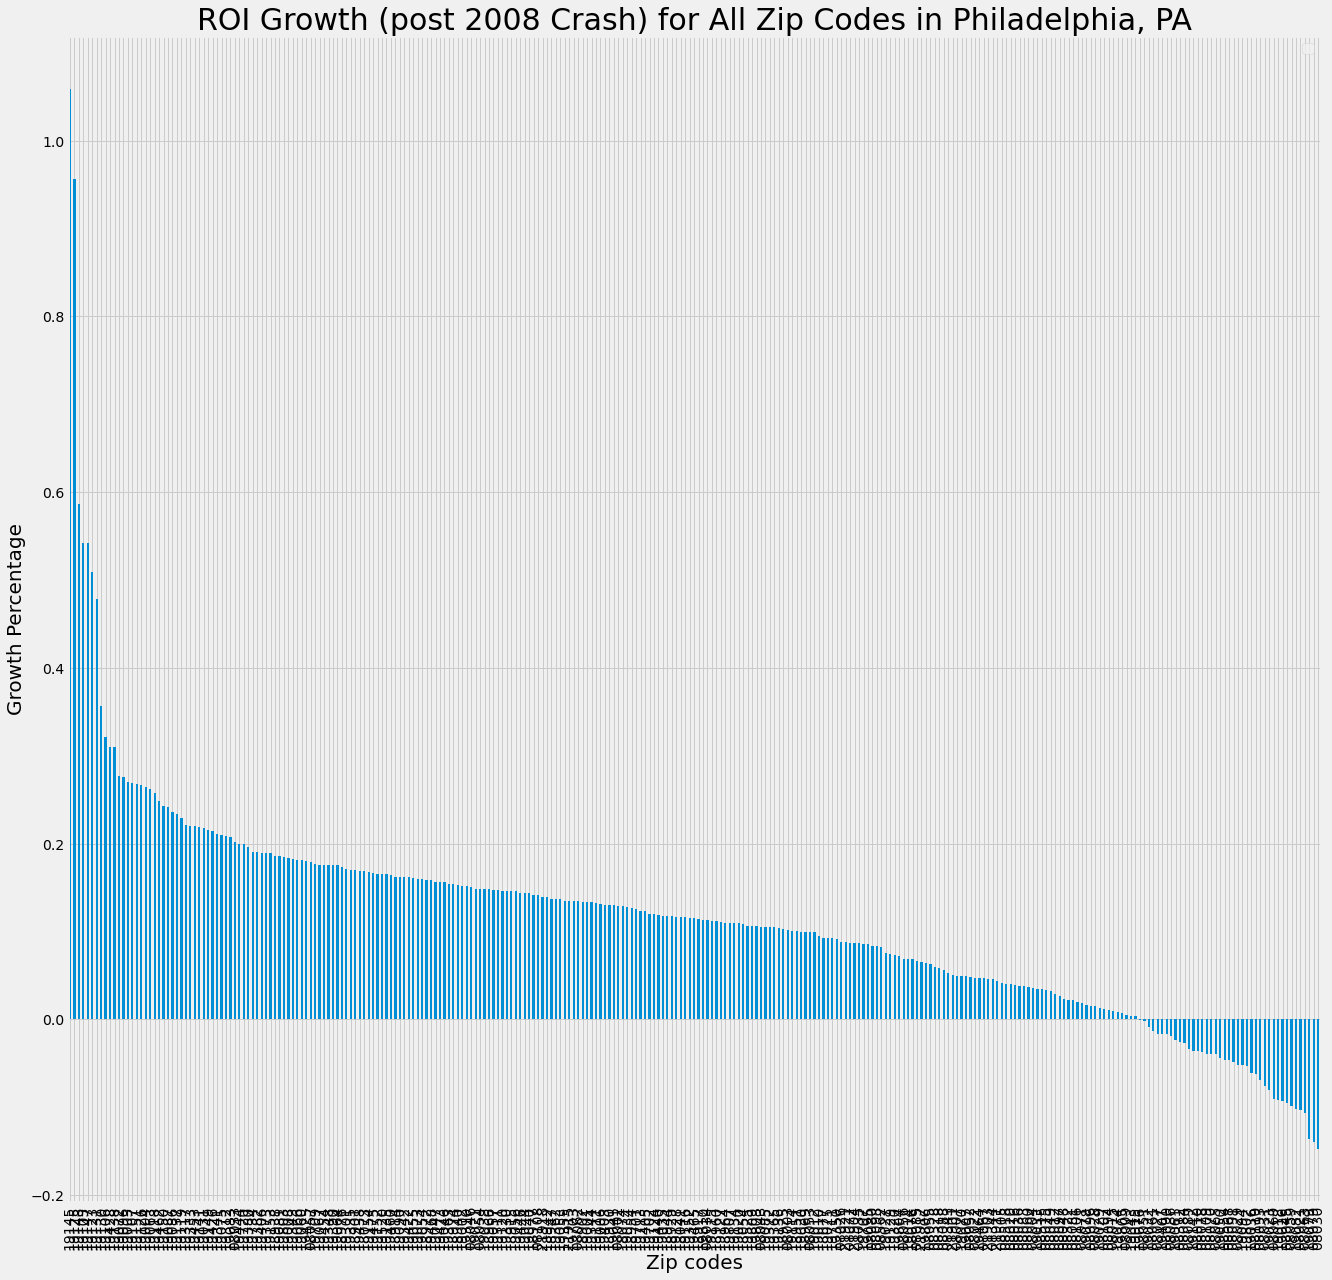

In [15]:
phil_by_growth2.plot.bar(x='RegionName', y='growth2',figsize=(20,20))
plt.title('ROI Growth (post 2008 Crash) for All Zip Codes in Philadelphia, PA', fontsize=30)
plt.legend('')
plt.xlabel('Zip codes',fontsize=20)
plt.ylabel('Growth Percentage',fontsize=20);


While the above graph gives us a good general sense of the RIO after the 2008 crash in the Philadelphia region, it's near impossible to see any specific zipcode - lets make a histogram to get a better sense of the frequency of the data, and a new bar graph with the top 10 zipcodes. 

In [16]:
# formatting for the rest of our visualizations
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

Text(0, 0.5, 'Zip Code Frequency')

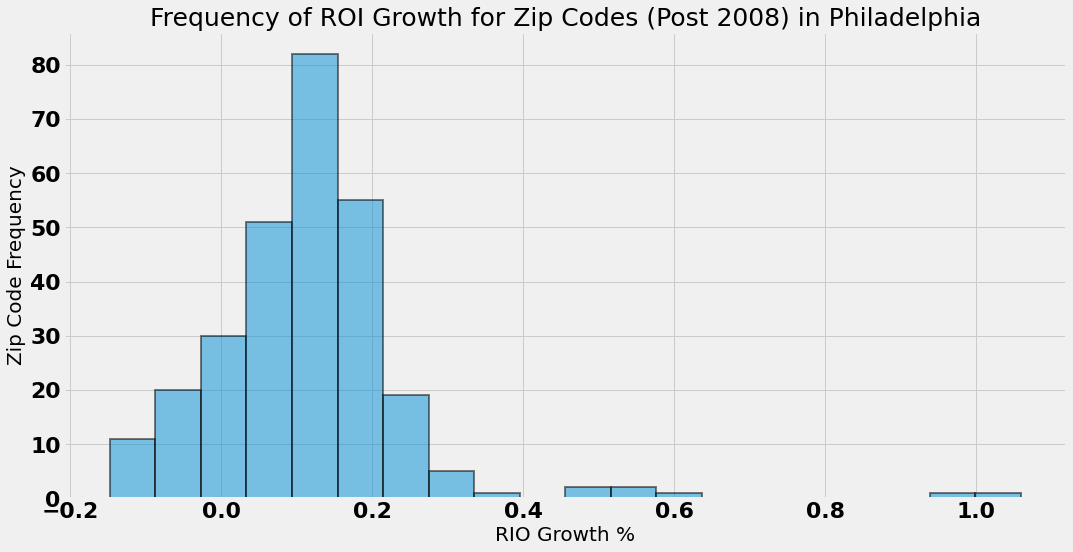

In [17]:
# making the histogram
phil_by_growth2.hist(bins = 20, figsize = (16, 8), alpha=0.5, edgecolor ="black", linewidth=2)
plt.title('Frequency of ROI Growth for Zip Codes (Post 2008) in Philadelphia', fontsize=25)
plt.xlabel('RIO Growth %',fontsize=20)
plt.ylabel('Zip Code Frequency',fontsize=20)


In the above histogram we see that most of the growth in the area was around 10-15%, with some zipcodes having a median *decrease* in their ROI. One zipcode seems to have more than doubled it's ROI. In the bargraph below, we'll be able to see which zipcode that is!  

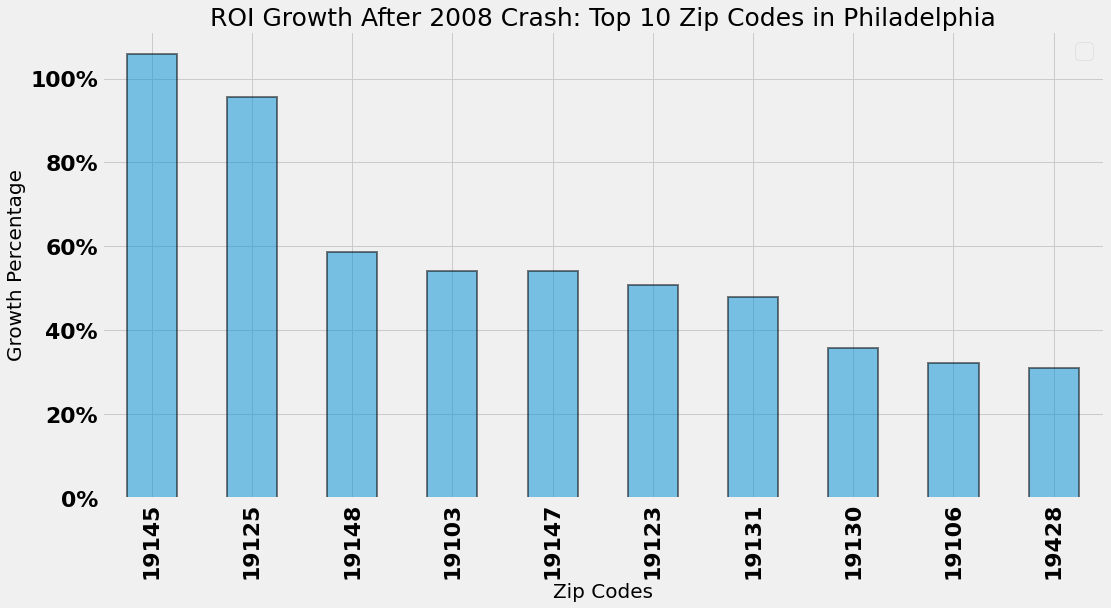

In [18]:
ax = phil_by_growth2.head(10).plot.bar(x='RegionName', y='growth2',figsize=(16,8), alpha = 0.5, edgecolor ="black", linewidth=2)
plt.title('ROI Growth After 2008 Crash: Top 10 Zip Codes in Philadelphia', fontsize=25)
plt.legend('')
ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
plt.xlabel('Zip Codes',fontsize=20)
plt.ylabel('Growth Percentage',fontsize=20);

Here we see that zipcode `19135` more than doubled it's ROI, closely followed by `19125`. Following this, the rest of the top ten zipcodes seem to have around a 60-30% ROI. 

## Melting the Data

In [19]:
# looking at our origional unsorted data again
phil_data.head()

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,t_growth,growth1,growth2
194,19111,Philadelphia,PA,Philadelphia,Philadelphia,84600.0,84500.0,84400.0,84200.0,84100.0,...,170600,171900,172700,173200,174000,175200,175800,1.078014,1.141844,0.132003
282,19124,Philadelphia,PA,Philadelphia,Philadelphia,43100.0,43000.0,42900.0,42700.0,42500.0,...,83000,83800,84300,84200,84900,86700,88200,1.046404,1.125290,0.119289
329,19446,Lansdale,PA,Philadelphia,Montgomery,155300.0,154900.0,154600.0,154200.0,153900.0,...,309300,308800,308900,310100,311600,314000,315900,1.034127,1.020605,0.144151
343,19020,Bensalem,PA,Philadelphia,Bucks,122000.0,121800.0,121600.0,121300.0,121000.0,...,253800,255400,256400,257500,257600,255600,253400,1.077049,1.204918,0.109457
351,19720,New Castle,DE,Philadelphia,New Castle,91300.0,92000.0,92600.0,93200.0,93600.0,...,173400,178700,185200,189000,189400,184700,179000,0.960570,1.111720,0.198928


In [20]:
#pulling out the date columns so we can more easily change the format later on
dates = phil_data.loc[:, ~phil_data.columns.isin(['RegionName','City', 'State', 'Metro', 'CountyName', 't_growth', 'growth1', 'growth2'])]

In [21]:
# adjusting the column names so we can use pd.melt later
column_names_to_change = {}

for column in dates.columns:
    column_names_to_change[column] = f'{column}-01'
    
phil_data.rename(columns=column_names_to_change, inplace=True)

phil_data.head()

,RegionName,City,State,Metro,CountyName,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,...,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,t_growth,growth1,growth2
194,19111,Philadelphia,PA,Philadelphia,Philadelphia,84600.0,84500.0,84400.0,84200.0,84100.0,...,170600,171900,172700,173200,174000,175200,175800,1.078014,1.141844,0.132003
282,19124,Philadelphia,PA,Philadelphia,Philadelphia,43100.0,43000.0,42900.0,42700.0,42500.0,...,83000,83800,84300,84200,84900,86700,88200,1.046404,1.125290,0.119289
329,19446,Lansdale,PA,Philadelphia,Montgomery,155300.0,154900.0,154600.0,154200.0,153900.0,...,309300,308800,308900,310100,311600,314000,315900,1.034127,1.020605,0.144151
343,19020,Bensalem,PA,Philadelphia,Bucks,122000.0,121800.0,121600.0,121300.0,121000.0,...,253800,255400,256400,257500,257600,255600,253400,1.077049,1.204918,0.109457
351,19720,New Castle,DE,Philadelphia,New Castle,91300.0,92000.0,92600.0,93200.0,93600.0,...,173400,178700,185200,189000,189400,184700,179000,0.960570,1.111720,0.198928


In [22]:
# taking the top 10 zipcodes and thier infomation
top_10_philly = phil_data.sort_values(by='growth2',ascending=False).head(10)
top_10_philly

,RegionName,City,State,Metro,CountyName,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,...,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,t_growth,growth1,growth2
666,19145,Philadelphia,PA,Philadelphia,Philadelphia,40500.0,40500.0,40500.0,40500.0,40400.0,...,195900,197100,198000,199500,202500,206500,208800,4.155556,1.975309,1.059172
3615,19125,Philadelphia,PA,Philadelphia,Philadelphia,32600.0,32700.0,32800.0,32800.0,32900.0,...,253900,255700,257100,258000,258500,260500,262300,7.046012,3.288344,0.956003
518,19148,Philadelphia,PA,Philadelphia,Philadelphia,41100.0,41100.0,41000.0,40900.0,40700.0,...,198600,199700,201000,202000,203800,207400,210100,4.111922,2.481752,0.586858
940,19103,Philadelphia,PA,Philadelphia,Philadelphia,195900.0,196800.0,197600.0,198400.0,199100.0,...,888500,898900,905000,909200,918200,930400,937300,3.784584,2.756508,0.542373
784,19147,Philadelphia,PA,Philadelphia,Philadelphia,56100.0,55600.0,55000.0,54500.0,54000.0,...,376600,377600,377400,378000,381200,386400,389400,5.941176,4.105169,0.541568
5214,19123,Philadelphia,PA,Philadelphia,Philadelphia,61000.0,60600.0,60300.0,59900.0,59600.0,...,392500,394900,397700,400600,403500,406700,409300,5.709836,4.311475,0.508662
531,19131,Philadelphia,PA,Philadelphia,Philadelphia,36700.0,36700.0,36800.0,36900.0,37000.0,...,83200,86600,90300,93600,95500,97000,98600,1.686649,1.130790,0.478261
1807,19130,Philadelphia,PA,Philadelphia,Philadelphia,76600.0,76700.0,76700.0,76600.0,76500.0,...,419000,422500,425600,428500,429700,429400,428700,4.596606,3.567885,0.356646
5510,19106,Philadelphia,PA,Philadelphia,Philadelphia,298900.0,298900.0,298900.0,298800.0,298700.0,...,1025300,1042700,1058500,1066200,1069800,1081700,1095700,2.665775,2.334560,0.321075
4747,19428,Conshohocken,PA,Philadelphia,Montgomery,114800.0,114800.0,114700.0,114700.0,114700.0,...,314700,313400,312900,313400,314500,316500,318400,1.773519,1.267422,0.310288


In [23]:
def after_crash(df):
    '''reduce our data so we only will see the dates/values after the market recoved from the 2008 crash''' 
    
    #droping all columns with infomation from before April 2011
    df_after_crash = df.drop(df.columns[5:185], axis=1,inplace=True)  
    return df_after_crash


after_crash(top_10_philly)
top_10_philly

,RegionName,City,State,Metro,CountyName,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,...,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,t_growth,growth1,growth2
666,19145,Philadelphia,PA,Philadelphia,Philadelphia,101400.0,100400.0,98100.0,96600.0,95700.0,...,195900,197100,198000,199500,202500,206500,208800,4.155556,1.975309,1.059172
3615,19125,Philadelphia,PA,Philadelphia,Philadelphia,132300.0,129400.0,126500.0,124400.0,122900.0,...,253900,255700,257100,258000,258500,260500,262300,7.046012,3.288344,0.956003
518,19148,Philadelphia,PA,Philadelphia,Philadelphia,130100.0,127500.0,124200.0,121300.0,119300.0,...,198600,199700,201000,202000,203800,207400,210100,4.111922,2.481752,0.586858
940,19103,Philadelphia,PA,Philadelphia,Philadelphia,605700.0,605100.0,599600.0,595200.0,596300.0,...,888500,898900,905000,909200,918200,930400,937300,3.784584,2.756508,0.542373
784,19147,Philadelphia,PA,Philadelphia,Philadelphia,251100.0,249600.0,248500.0,248900.0,250900.0,...,376600,377600,377400,378000,381200,386400,389400,5.941176,4.105169,0.541568
5214,19123,Philadelphia,PA,Philadelphia,Philadelphia,268600.0,262000.0,254900.0,251600.0,251900.0,...,392500,394900,397700,400600,403500,406700,409300,5.709836,4.311475,0.508662
531,19131,Philadelphia,PA,Philadelphia,Philadelphia,66200.0,65800.0,66100.0,66500.0,66800.0,...,83200,86600,90300,93600,95500,97000,98600,1.686649,1.130790,0.478261
1807,19130,Philadelphia,PA,Philadelphia,Philadelphia,316300.0,315000.0,311400.0,308200.0,306900.0,...,419000,422500,425600,428500,429700,429400,428700,4.596606,3.567885,0.356646
5510,19106,Philadelphia,PA,Philadelphia,Philadelphia,825800.0,826600.0,821800.0,815800.0,814200.0,...,1025300,1042700,1058500,1066200,1069800,1081700,1095700,2.665775,2.334560,0.321075
4747,19428,Conshohocken,PA,Philadelphia,Montgomery,241700.0,240200.0,239700.0,239300.0,238100.0,...,314700,313400,312900,313400,314500,316500,318400,1.773519,1.267422,0.310288


In [24]:
def melt_data(df, plot = False):
    ''' Here we are going to melt the data, so we can have our timeseries data in a more traditional format. 
        This will allow us to use timeseries modeling teqniques later on.'''
    
    # melting the data so we have it in the long version, instead of wide
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName', 't_growth', 'growth1', 'growth2'], var_name='time')
    # makeing our new column `time` a datetime variable 
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    # getting rid of rows that are missing `value` values
    melted_nonan = melted.dropna(subset=['value'])
    #set `time` as index so we can model it as a time series dataset
    melted_nonan.set_index('time',inplace=True)
    # drop all the columns we no longer need
    if plot: 
        melted_nonan.drop(labels = ['City', 'State', 'Metro', 'CountyName', 't_growth', 'growth1', 'growth2'], axis=1, inplace=True)
    else:
        melted_nonan.drop(labels = ['RegionName','City', 'State', 'Metro', 'CountyName', 't_growth', 'growth1', 'growth2'], axis=1, inplace=True)
    return  melted_nonan


In [25]:
# handy list of just the zipcodes names
zip_list = []
for zip_code in top_10_philly['RegionName']:
    zip_list.append(zip_code)
zip_list

['19145',
 '19125',
 '19148',
 '19103',
 '19147',
 '19123',
 '19131',
 '19130',
 '19106',
 '19428']

In [26]:
top_10_melt = []

#using a for loop to melt the data for each of our zipcodes individually
for zip_code in top_10_philly['RegionName']:
     top_10_melt.append({
         'zip_code': zip_code,
         'data': melt_data(top_10_philly.loc[(top_10_philly['RegionName'] == zip_code)])
     })

#pulling out one timeseries set to make sure it worked
top_10_melt[0]['data']

,value
time,
2011-04-01,101400.0
2011-05-01,100400.0
2011-06-01,98100.0
2011-07-01,96600.0
2011-08-01,95700.0
...,...
2017-12-01,198000.0
2018-01-01,199500.0
2018-02-01,202500.0


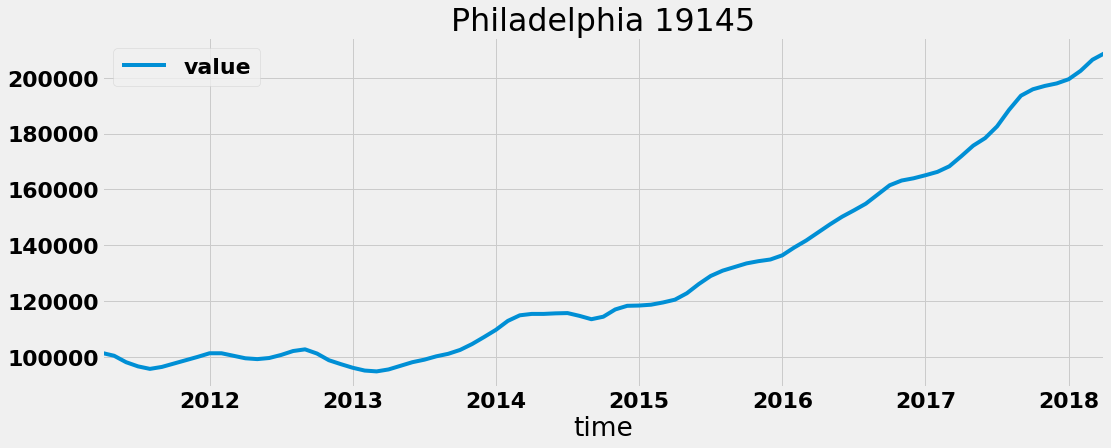

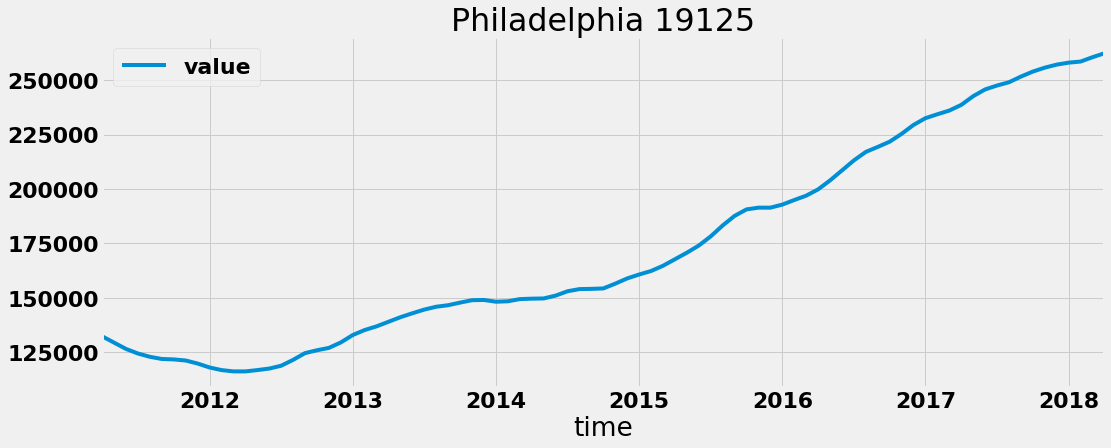

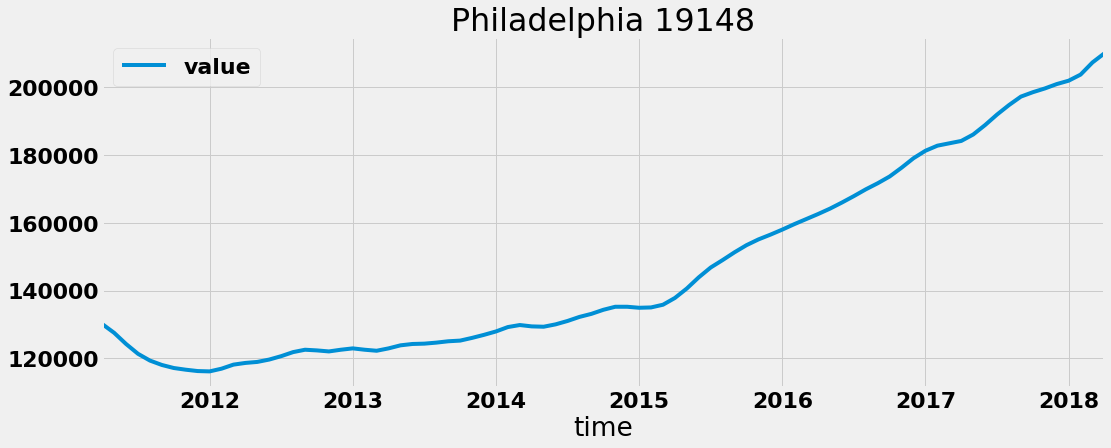

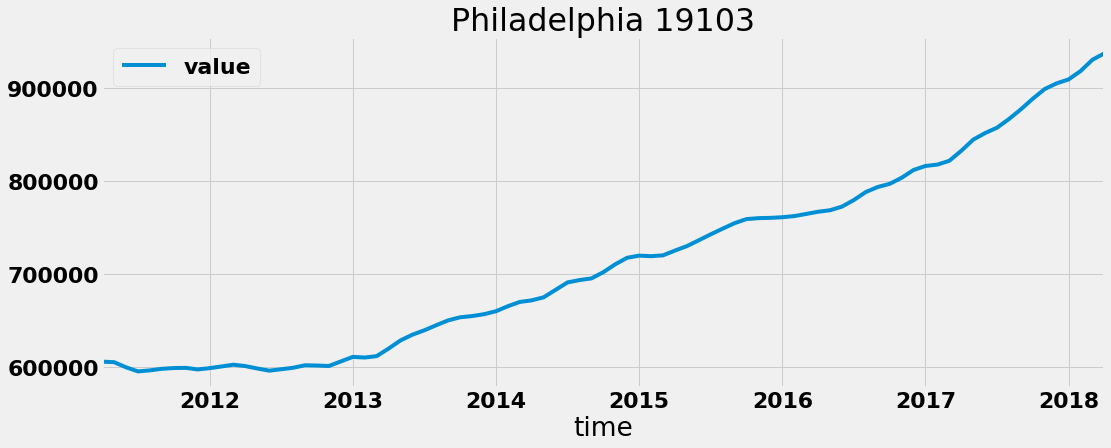

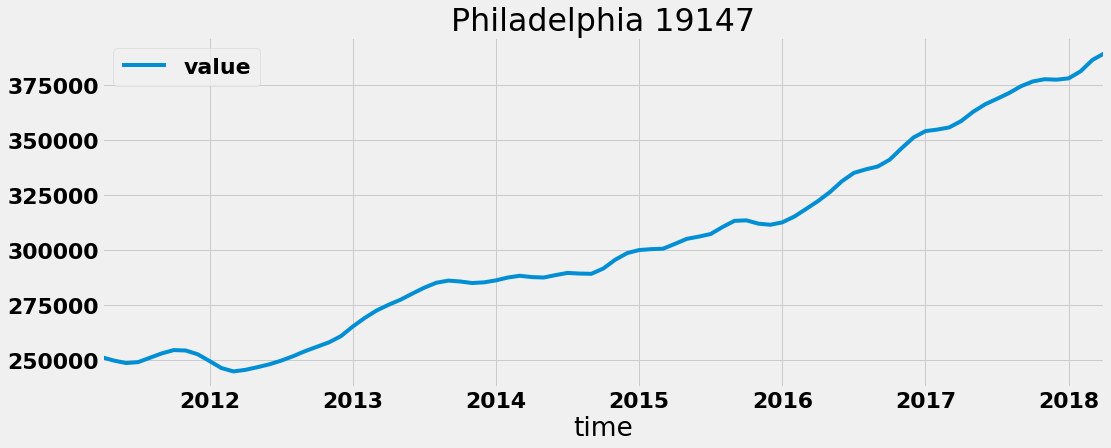

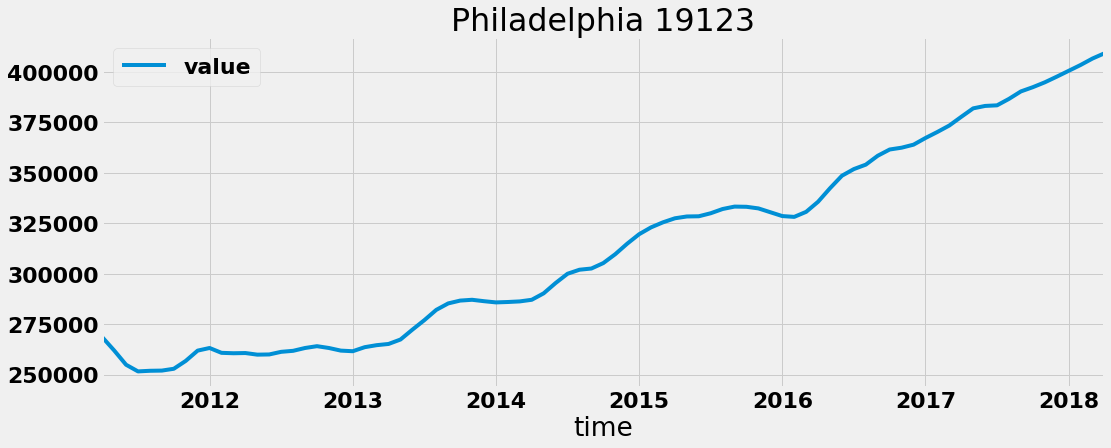

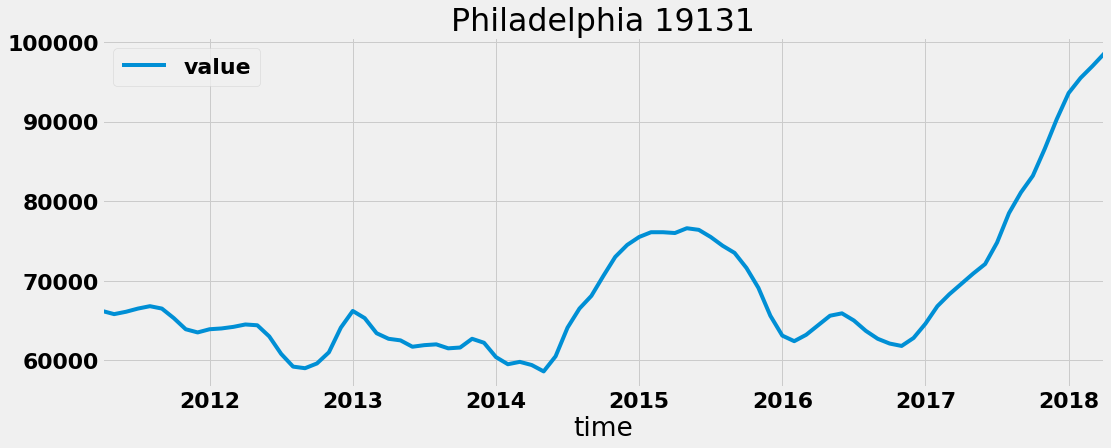

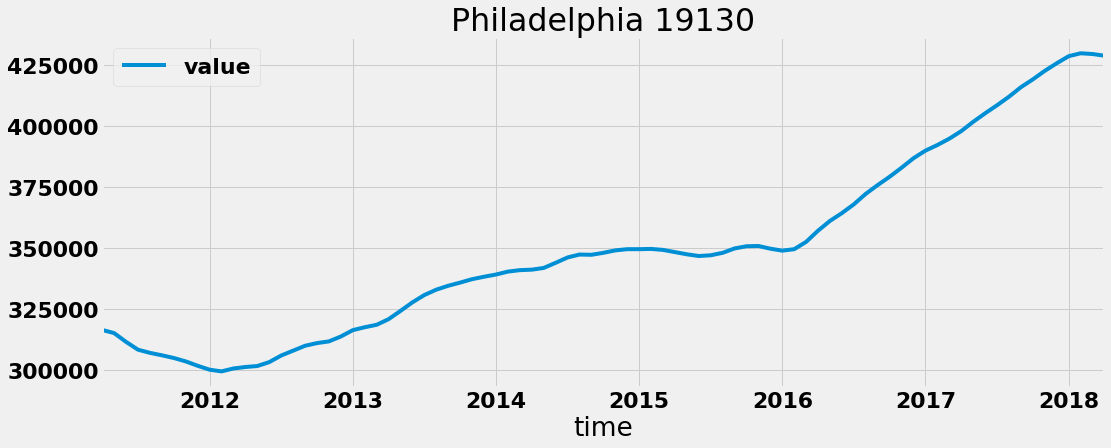

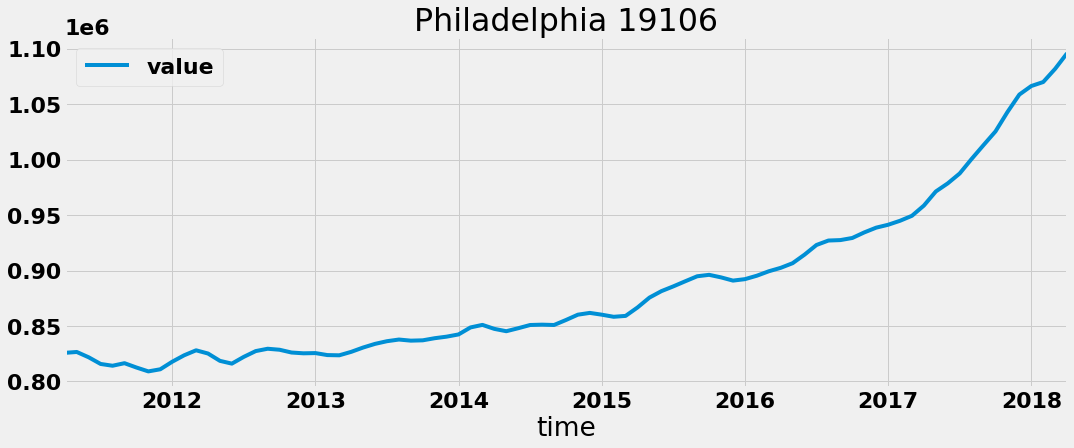

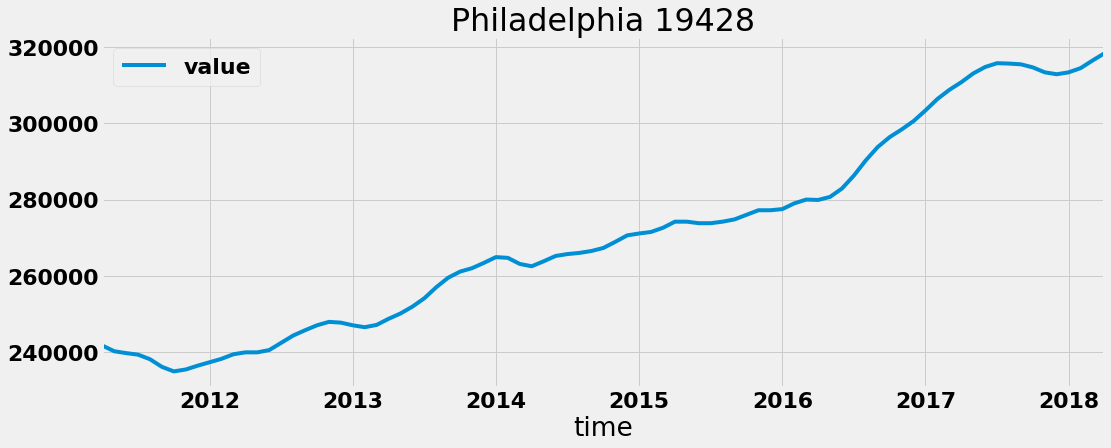

In [27]:
# Plotting the timeseries data for the top 10 zipcodes
for zip_code_melt in top_10_melt:
    zip_code_melt['data'].plot(title=  f"Philadelphia {zip_code_melt['zip_code']}", figsize = (16,6));

In [28]:
color_list = ["#d0e038","#5757c2","#2c4875","#8a508f","#f57ec7","#eb4c4c","#ff8531","#0d9e10","#ffd380","#56e3d3"]
color_map = dict(zip(zip_list, color_list))


In [29]:
#pivoting so that each zipcode becomes a column for our visualization
plot_df = melt_data(top_10_philly, plot = True).pivot(columns='RegionName', values='value')
#plot_df

RegionName,19103,19106,19123,19125,19130,19131,19145,19147,19148,19428
time,,,,,,,,,,
2011-04-01,605700.0,825800.0,268600.0,132300.0,316300.0,66200.0,101400.0,251100.0,130100.0,241700.0
2011-05-01,605100.0,826600.0,262000.0,129400.0,315000.0,65800.0,100400.0,249600.0,127500.0,240200.0
2011-06-01,599600.0,821800.0,254900.0,126500.0,311400.0,66100.0,98100.0,248500.0,124200.0,239700.0
2011-07-01,595200.0,815800.0,251600.0,124400.0,308200.0,66500.0,96600.0,248900.0,121300.0,239300.0
2011-08-01,596300.0,814200.0,251900.0,122900.0,306900.0,66800.0,95700.0,250900.0,119300.0,238100.0
...,...,...,...,...,...,...,...,...,...,...
2017-12-01,905000.0,1058500.0,397700.0,257100.0,425600.0,90300.0,198000.0,377400.0,201000.0,312900.0
2018-01-01,909200.0,1066200.0,400600.0,258000.0,428500.0,93600.0,199500.0,378000.0,202000.0,313400.0
2018-02-01,918200.0,1069800.0,403500.0,258500.0,429700.0,95500.0,202500.0,381200.0,203800.0,314500.0


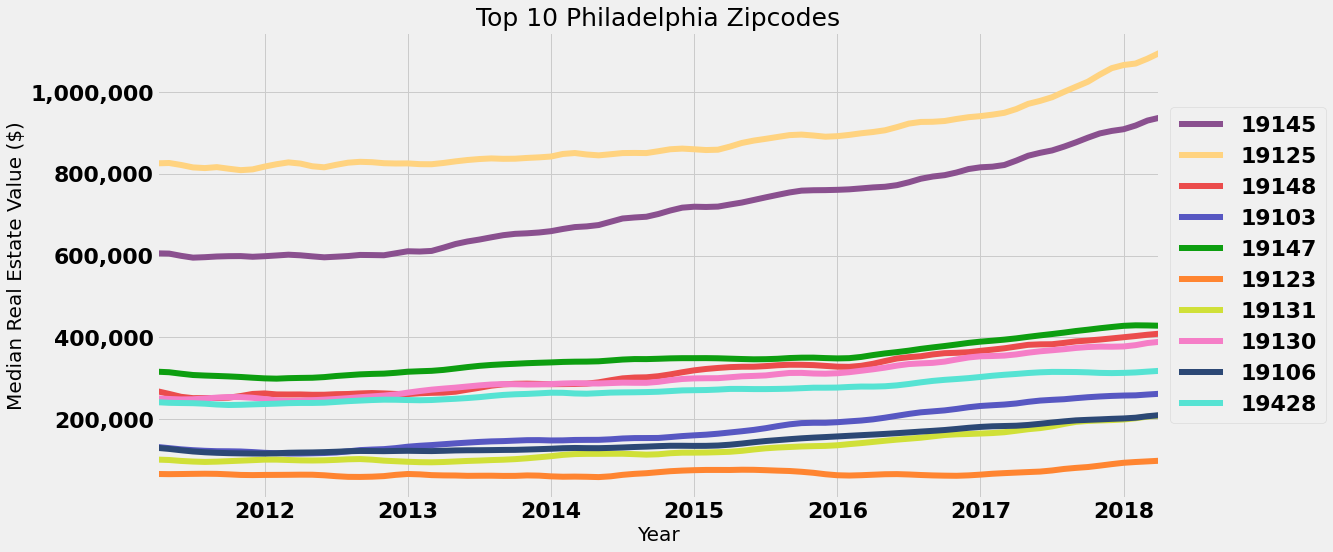

In [51]:
# creating a pretty graph that plots all of our zxipcodes in one place!
ax = plot_df.plot.line(color = color_map, figsize = (16,8), linewidth=6)
ax.set_yticklabels([0, "200,000", "400,000", "600,000", "800,000", "1,000,000"])
ax.set_xlabel("Year", fontsize=20)
ax.set_ylabel("Median Real Estate Value ($)", fontsize=20)
# code taken from https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
ax.legend(zip_list, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Top 10 Philadelphia Zipcodes', fontsize=25)
plt.show();


Now that we have a basic view of how to zipcodes values changed over time, lets check for stationality for each zipcode. We can see above that all of these zipcodes have an upward *trend*, but lets double check this using the Dickey Fuller Test and the rolling mean. We need to make try and make our data stationary in order to use traditional time series modeling. 

In [31]:
# # Create a function to check for the stationarity of a given time series using rolling stats and DF test
# # Code taken from https://github.com/learn-co-curriculum/dsc-removing-trends-lab

# def stationarity_check(TS, TS_zip):
    
#     # Import adfuller
#     from statsmodels.tsa.stattools import adfuller
#    
#     # Calculate rolling statistics
#     roll_mean = TS.rolling(window=8, center=False).mean()
#     roll_std = TS.rolling(window=8, center=False).std()
    
#     # Perform the Dickey Fuller Test
#     dftest = adfuller(TS['value'])
    
#     # Plot rolling statistics:
#     fig = plt.figure(figsize=(12,6))
#     plt.plot(TS, color='blue',label='Original')
#     plt.plot(roll_mean, color='red', label='Rolling Mean')
#     plt.plot(roll_std, color='black', label = 'Rolling Std')
#     plt.legend(loc='best')
#     plt.title(f"{TS_zip} Rolling Mean & Standard Deviation")
#     plt.show(block=False)
    
#     # Print Dickey-Fuller test results
#     print('Results of Dickey-Fuller Test: \n')

#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
#                                              '#Lags Used', 'Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print(dfoutput)
    
#     return None

In [32]:
# # checking for stationality in our top 10 zipcodes
# for zip_code in top_10_melt:
#     stationarity_check(zip_code['data'], zip_code['zip_code'])

None of our above zipcodes pass the Dicky Fuller test (p-values are much to high) and all of the rolling means show us that they all share an upward linear trend. This means that *none of our data is stationary*. I want to use facebook `prophet` to model and predict the data, but before that we'll have to remove the trend. Our data doesn't have a lot of seasonality (at least just by eyeballing it) but it does have a trend.

To start off, we'll look at the top zipcode, and then try applying the methods we use on it to the rest of the top 10 zipcodes and see if that works. 

I did try taking `np.sqrt` and `np.log`, but it didn't really remove the trends in the way I wanted. Lets try taking the rolling mean and see if that helps at all. 

In [33]:
# # taking the rolling mean
# roll_mean = top_10_melt[0]['data'].rolling(window=8, center=False).mean()
# data_minus_roll_mean = top_10_melt[0]['data'] - roll_mean
# data_minus_roll_mean

In [34]:
# # dropping missing values
# data_minus_roll_mean.dropna(inplace=True)

In [35]:
# # plotting the subtracted rolling mean
# fig = plt.figure(figsize=(11,7))
# plt.plot(data_minus_roll_mean, color='blue',label= 'Median Sales')
# plt.legend(loc='best')
# plt.title('Sales while the rolling mean is subtracted')
# plt.show(block=False)

In [36]:
# stationarity_check(data_minus_roll_mean, top_10_melt[0]['zip_code'])

While our data looks better here, our p-value is way to high to consider this data stationary. Next we'll try the exponentially weighted rolling mean.

In [37]:
# # Use Pandas ewm() to calculate Exponential Weighted Moving Average
# exp_roll_mean = top_10_melt[0]['data'].ewm(halflife=2).mean()
# data_minus_exp_roll_mean = top_10_melt[0]['data'] - exp_roll_mean
# #data_minus_exp_roll_mean.head(15)

In [38]:
# fig = plt.figure(figsize=(11,7))
# plt.plot(data_minus_exp_roll_mean, color='blue', label='Median Sales')
# plt.legend(loc='best')
# plt.title('Sales while the exponential weighted rolling mean is subtracted')
# plt.show(block=False)

In [39]:
# stationarity_check(data_minus_exp_roll_mean, top_10_melt[0]['zip_code'])

That performed worse than the rolling mean - let's try taking the difference of the time periods (this means subtracting previous 'periods' from the data points to try and smooth out the trend we see. 

In [40]:
# # I tried out a few different period lengths - this was the one with the best results
# data_diff = top_10_melt[0]['data'].diff(periods =3)
# #data_diff.head(15)


In [41]:
# fig = plt.figure(figsize=(11,7))
# plt.plot(data_diff, color='blue',label='Median Sales')
# plt.legend(loc='best')
# plt.title('Differenced sales series')
# plt.show(block=False)

In [42]:
# data_diff.dropna(inplace=True)
# stationarity_check(data_diff, top_10_melt[0]['zip_code'])

This seems to be the best we can do with the data we have on hand in this dataset. We will continue with this version of the data, but it should be noted that the data is not stationary and this violates the assumption of ARIMA - the modeling method we will use. 

This may be because the dataset uses the median monthly amount - thereby not being granular enough to remove the trend. Inflation is present in this dataset, and it could be that using ['deflating'](https://towardsdatascience.com/the-what-and-why-of-inflation-adjustment-5eedb496e080) would be helpfull, but that would require pulling in additional datasets. Due to the time-sensitive nature of this assignment, we did not take this step, but it could be a meaningful direction for future attempts. 

That being said, let's apply this difference to all of our zipcodes and see if it helps at all. 

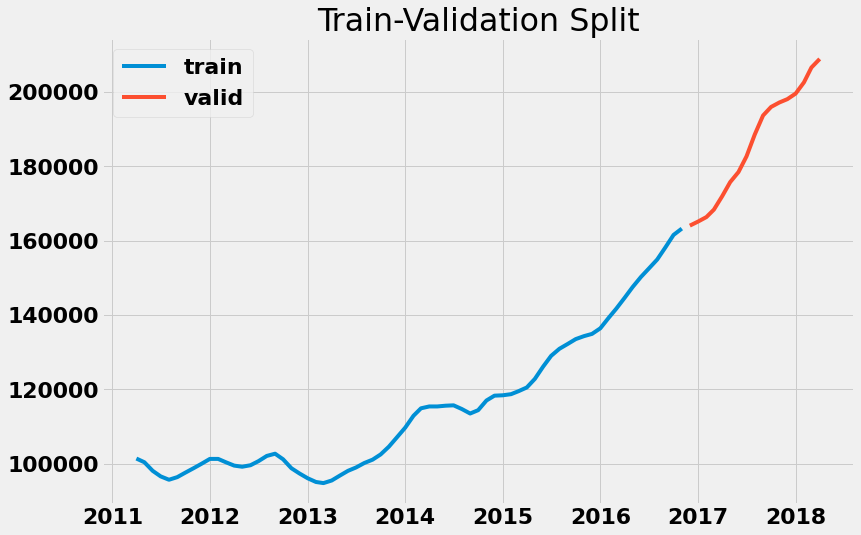

In [43]:
# creating a training and validation set of our data

trainvalid_split = []

for melted in top_10_melt:
 # find the index which allows us to split off 20% of the data
    cutoff = round(melted['data'].shape[0]*0.8)
    trainvalid_split.append({
        'train': melted['data'][:cutoff],
        'valid': melted['data'][cutoff:]
    })

# checking that it worked!
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(trainvalid_split[0]['train'], label='train')
ax.plot(trainvalid_split[0]['valid'], label='valid')
ax.set_title('Train-Validation Split');
plt.legend();

In [44]:
def sarima_elements(TS):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(TS,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue
                
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    out = ans_df.loc[ans_df['aic'].idxmin()]
    return out

In [45]:
sarima_elements(trainvalid_split[2]['train'])

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           642.402
Name: 59, dtype: object

In [66]:
# Plug the optimal parameter values into a new SARIMAX model

def arima_model(df_train, df_valid, zipcode):
    elements = sarima_elements(df_train)
    # print elements from sarima model
    print(elements)
    
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX((df_train), order=elements[0], seasonal_order=elements[1],\
                                            enforce_stationarity=False, enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()
    prediction = output.get_forecast(steps=36)
    # Confidence intervals of forecasts
    pred_conf = prediction.conf_int()
    
    #print(df['zipcode'])
    print(output.summary().tables[1])
    output.plot_diagnostics(figsize=(15, 18))
    
    # Fit the model and print results
    output = ARIMA_MODEL.fit()
    #forcast 3 years into the future
    prediction = output.get_forecast(steps=36)
    # Confidence intervals of forecasts
    pred_conf = prediction.conf_int()
    
    # plot model and predictions
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(df_train, label= 'Training Data')
    ax.plot(df_valid, label= 'Validity Data')
    prediction.predicted_mean.plot(ax=ax, label='Forecasted Value')
    ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
    plt.title(f"{zipcode} Forcast", fontsize=30)
    ax.set_xlabel('Years')
    ax.set_ylabel('Home Values')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    # returing the first 17 predicted values, to later pair with our validation data to find the RMSE
    return prediction.predicted_mean[:17]


pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           642.402
Name: 59, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6993      0.116      6.016      0.000       0.471       0.927
ma.L1          0.6953      0.121      5.768      0.000       0.459       0.932
ma.S.L12      -0.2618      0.061     -4.319      0.000      -0.381      -0.143
sigma2      2.483e+05   5.67e+04      4.376      0.000    1.37e+05    3.59e+05


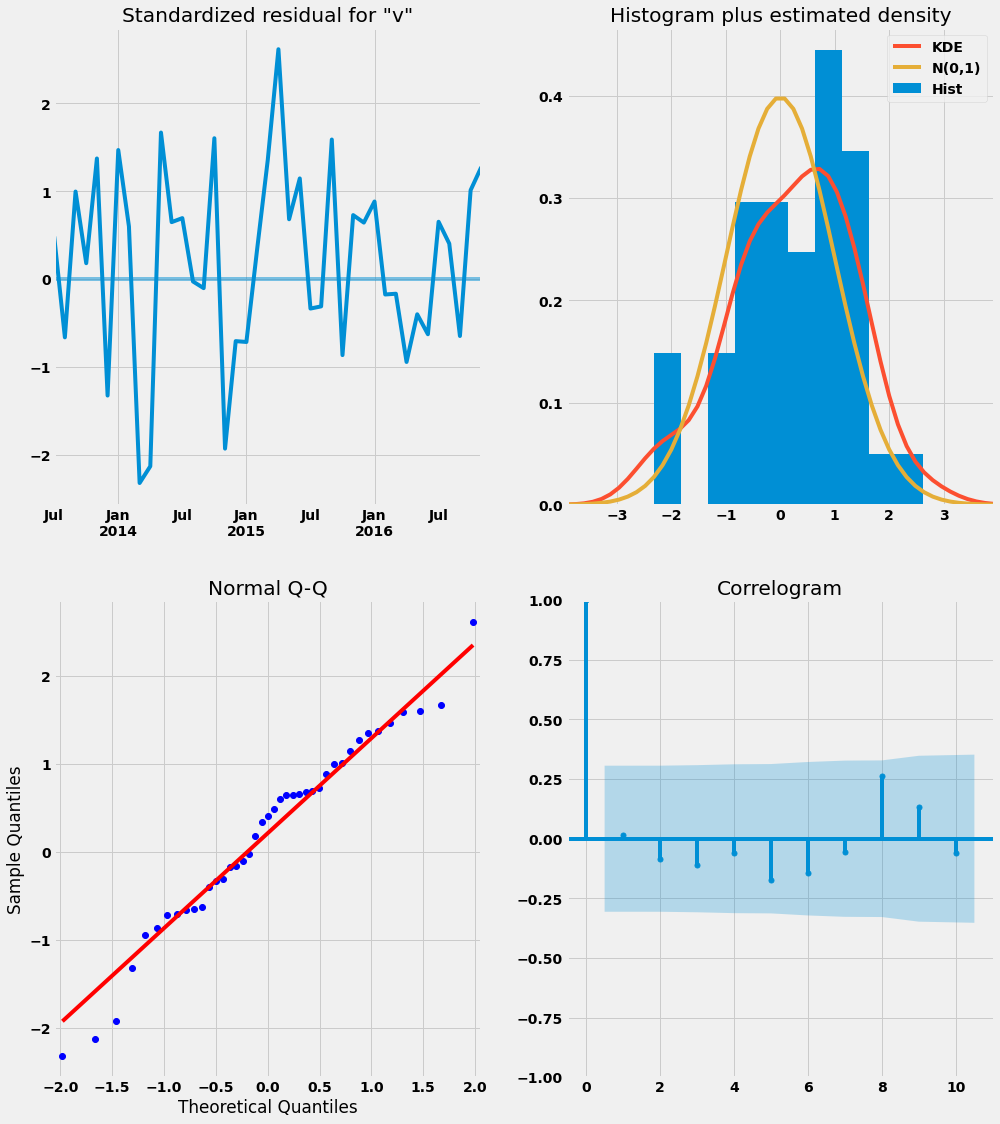

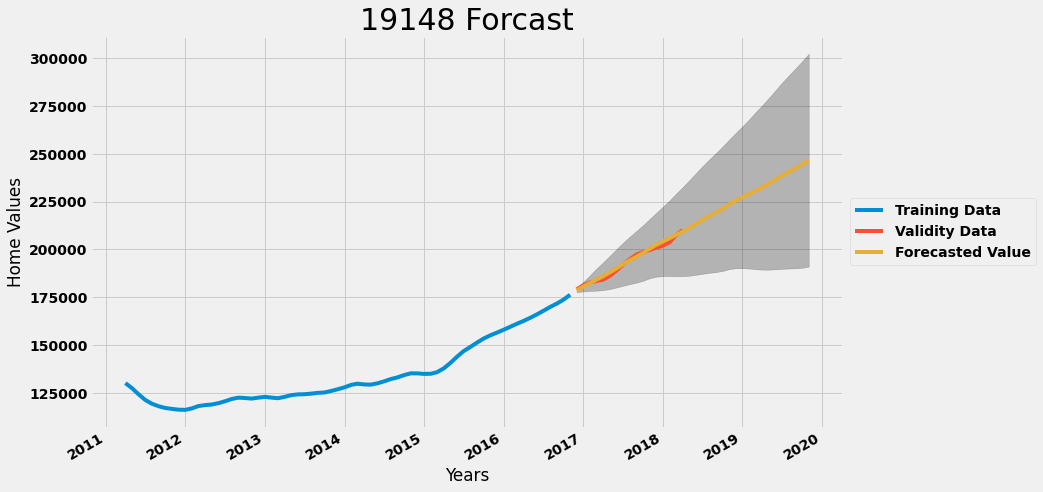

In [112]:
# checking that the model works
toy_data = arima_model(trainvalid_split[2]['train'], trainvalid_split[2]['valid'], zip_list[2])


In [113]:
#seeing our results when we call the end result on it's own 
toy_data

2016-12-01    178621.209959
2017-01-01    180591.472112
2017-02-01    182462.589394
2017-03-01    184189.257987
2017-04-01    185985.270754
2017-05-01    187929.432476
2017-06-01    190087.715342
2017-07-01    192209.576000
2017-08-01    194252.434207
2017-09-01    196129.718165
2017-10-01    198110.109816
2017-11-01    200438.035195
2017-12-01    202453.234055
2018-01-01    204209.516374
2018-02-01    205931.007156
2018-03-01    207553.048649
2018-04-01    209275.900380
Freq: MS, Name: predicted_mean, dtype: float64

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           683.264
Name: 59, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6806      0.180      3.788      0.000       0.328       1.033
ma.L1          0.6872      0.179      3.843      0.000       0.337       1.038
ma.S.L12      -0.1925      0.102     -1.884      0.060      -0.393       0.008
sigma2      1.016e+06   3.19e+05      3.189      0.001    3.91e+05    1.64e+06


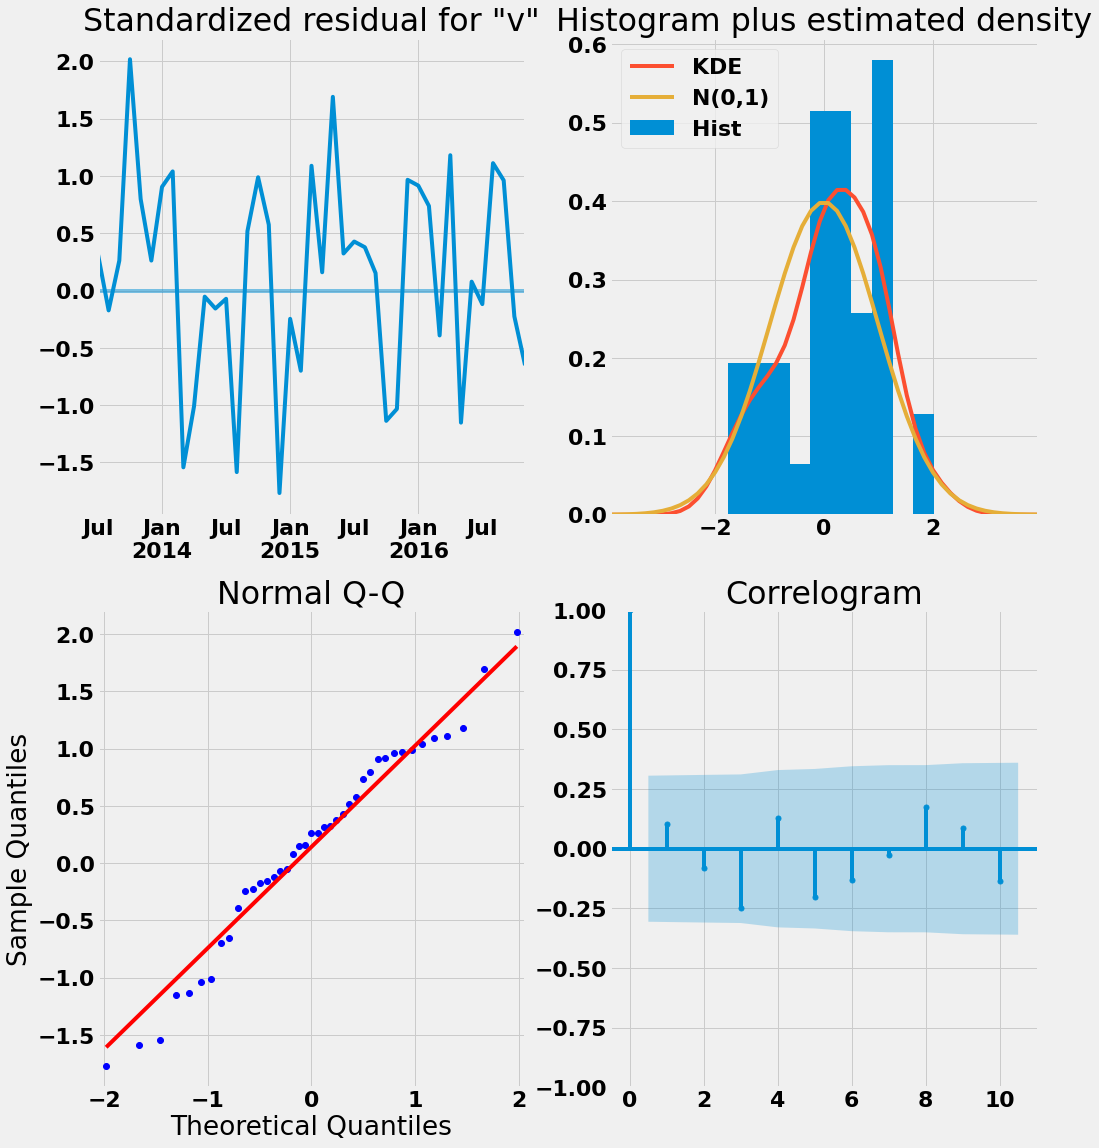

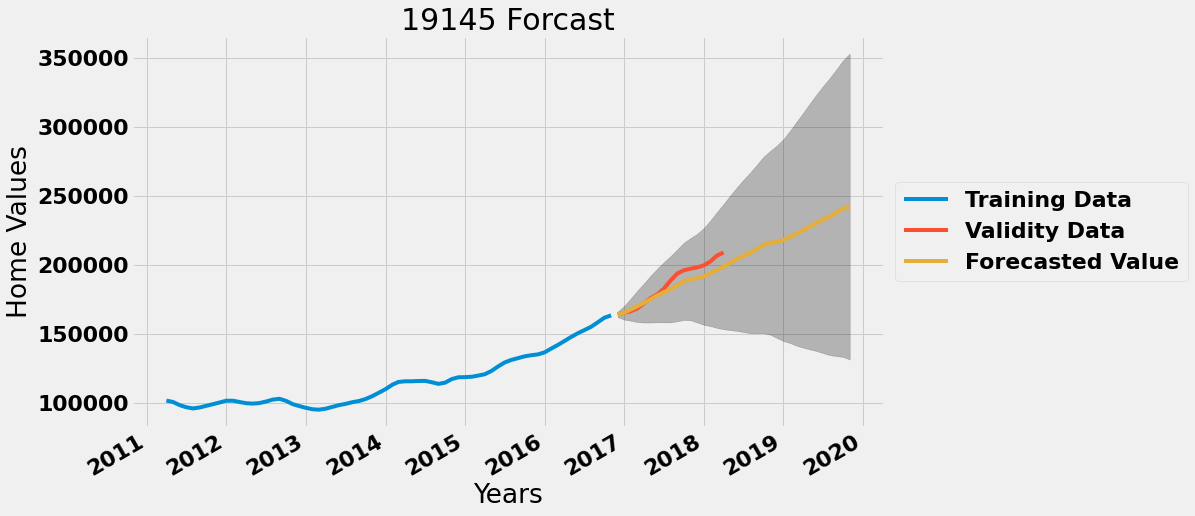

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic            701.57
Name: 59, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5020      0.149      3.365      0.001       0.210       0.794
ma.L1          1.2442      0.129      9.662      0.000       0.992       1.497
ma.S.L12      44.6854    215.297      0.208      0.836    -377.288     466.659
sigma2       401.6789   3977.686      0.101      0.920   -7394.443    8197.800


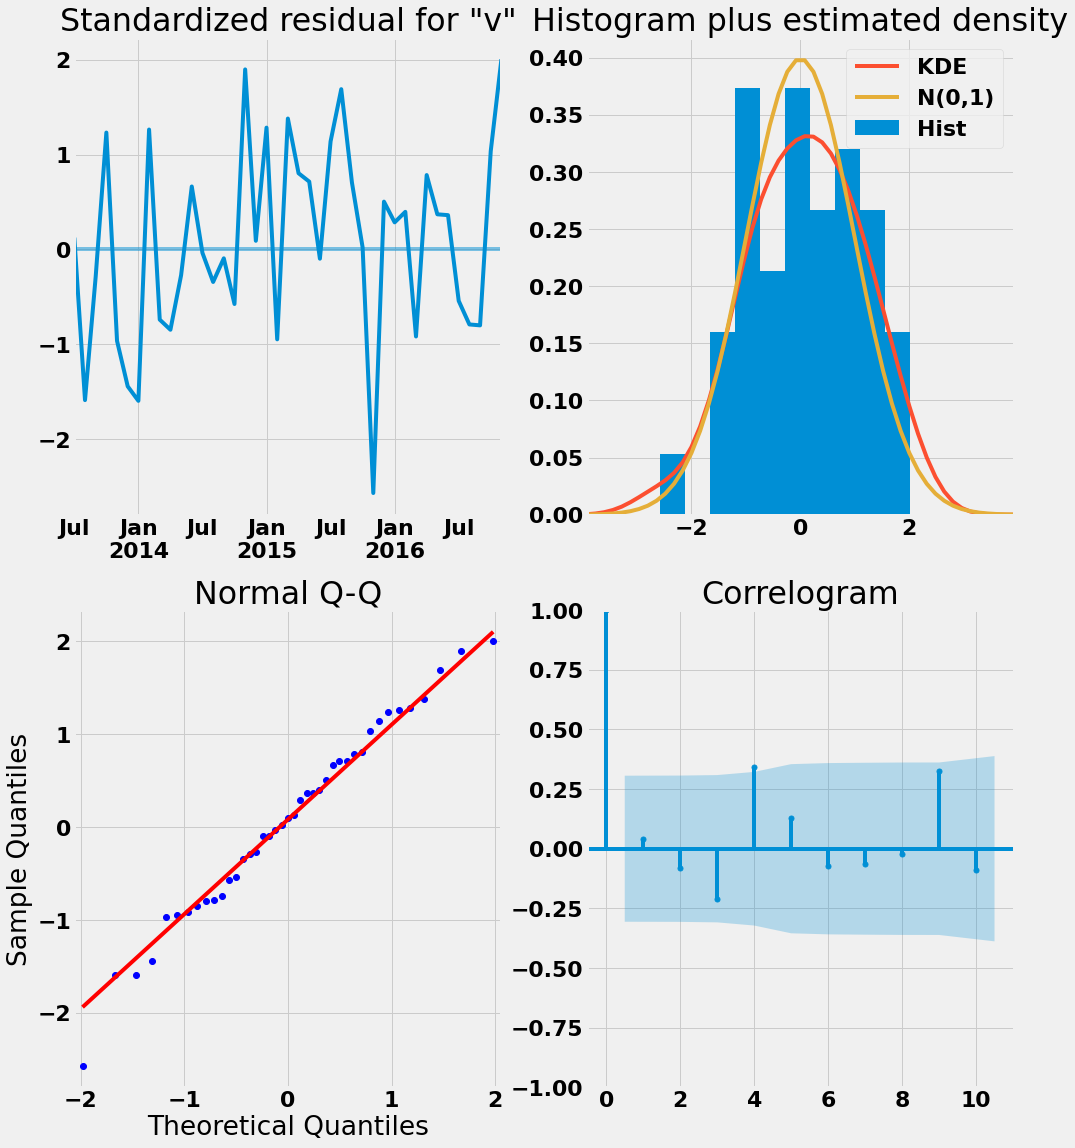

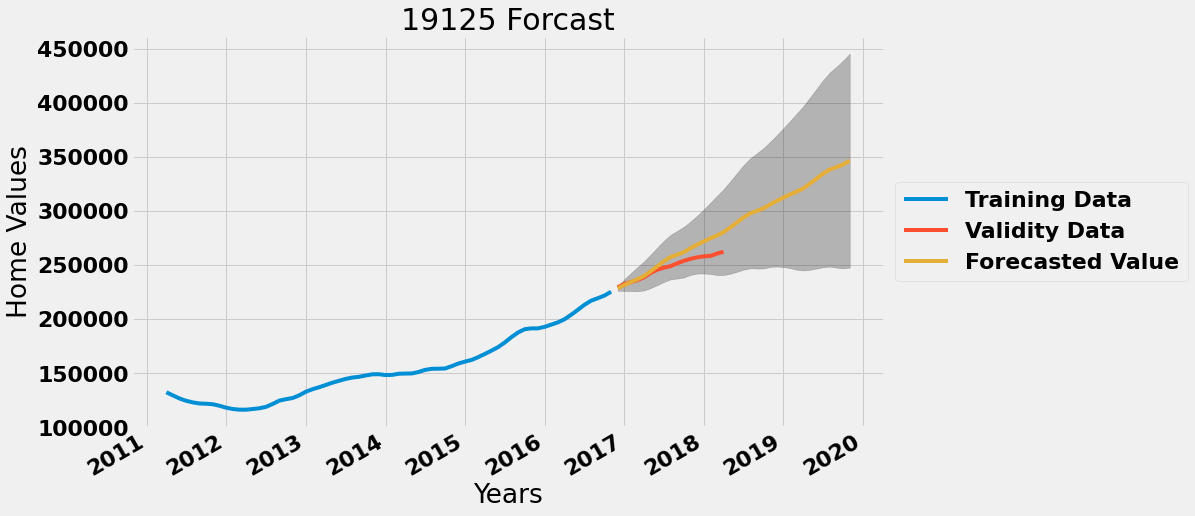

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           642.402
Name: 59, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6993      0.116      6.016      0.000       0.471       0.927
ma.L1          0.6953      0.121      5.768      0.000       0.459       0.932
ma.S.L12      -0.2618      0.061     -4.319      0.000      -0.381      -0.143
sigma2      2.483e+05   5.67e+04      4.376      0.000    1.37e+05    3.59e+05


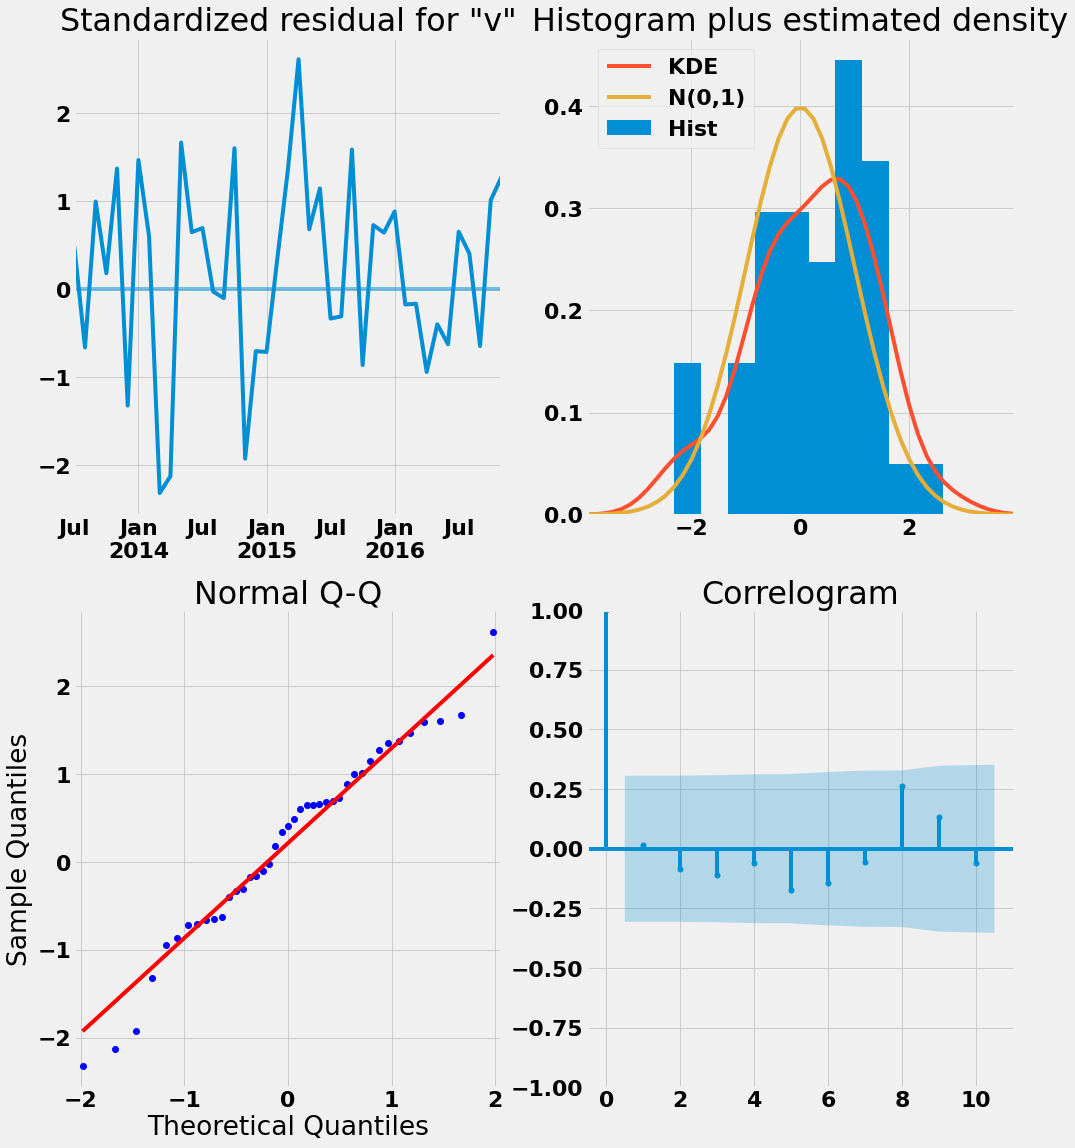

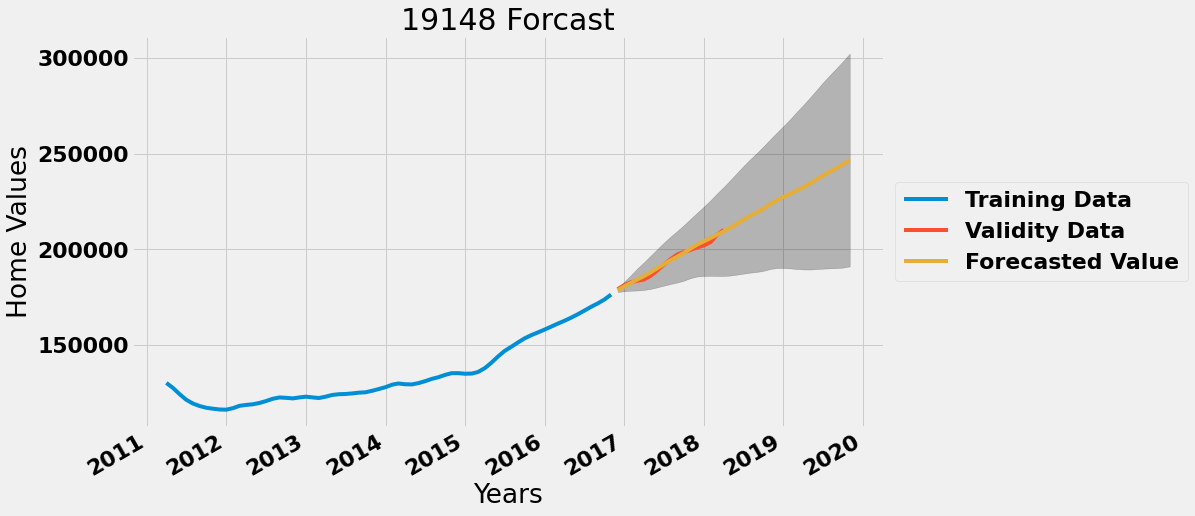

pdq         (0, 1, 1)
pdqs    (1, 1, 1, 12)
aic           771.885
Name: 31, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8359      0.092      9.103      0.000       0.656       1.016
ar.S.L12       0.0610      0.053      1.151      0.250      -0.043       0.165
ma.S.L12      -0.0725      0.114     -0.638      0.523      -0.295       0.150
sigma2      7.813e+06   3.32e-10   2.36e+16      0.000    7.81e+06    7.81e+06


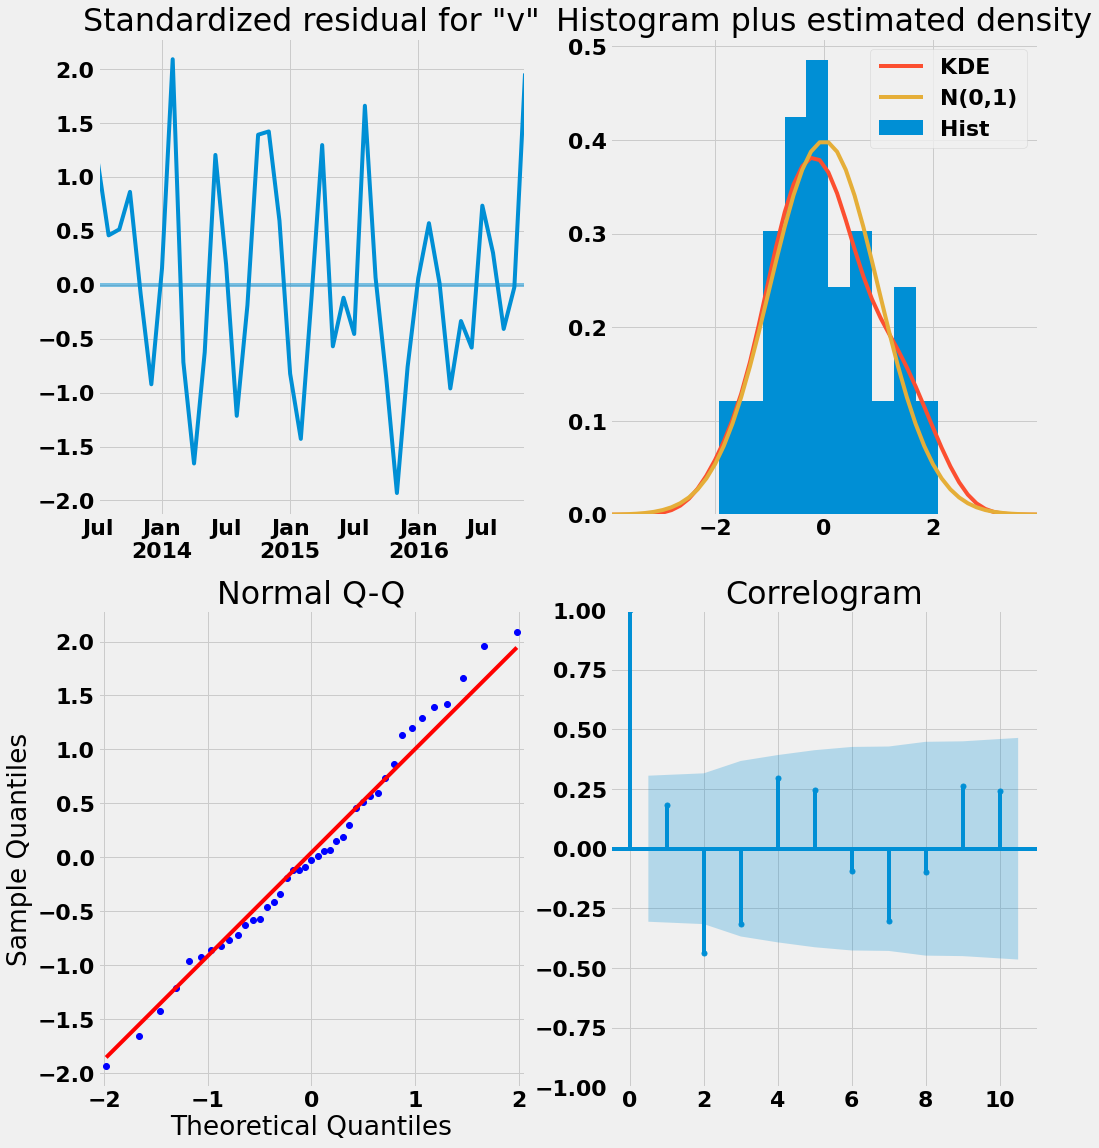

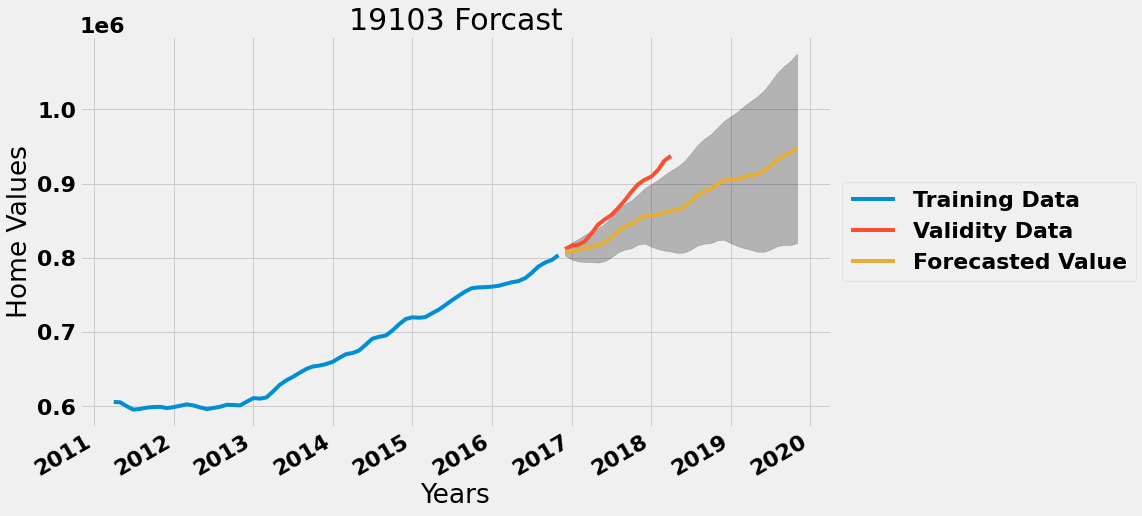

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           723.723
Name: 63, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5588      0.190      2.934      0.003       0.185       0.932
ma.L1          1.1666      0.103     11.357      0.000       0.965       1.368
ar.S.L12       0.0639      0.033      1.937      0.053      -0.001       0.128
ma.S.L12      -0.1099      0.127     -0.868      0.386      -0.358       0.138
sigma2      1.838e+06   1.93e-08    9.5e+13      0.000    1.84e+06    1.84e+06


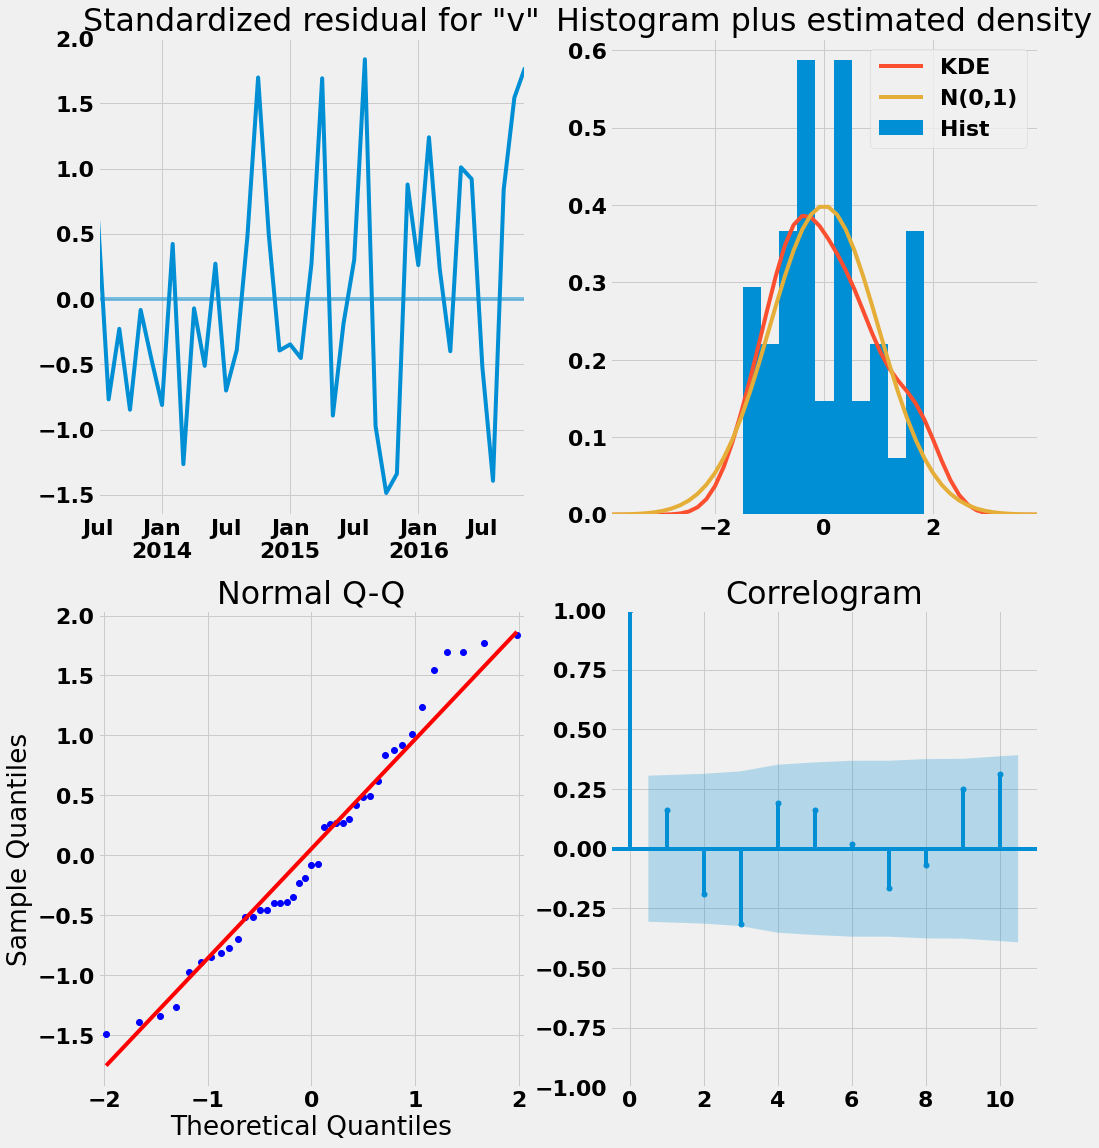

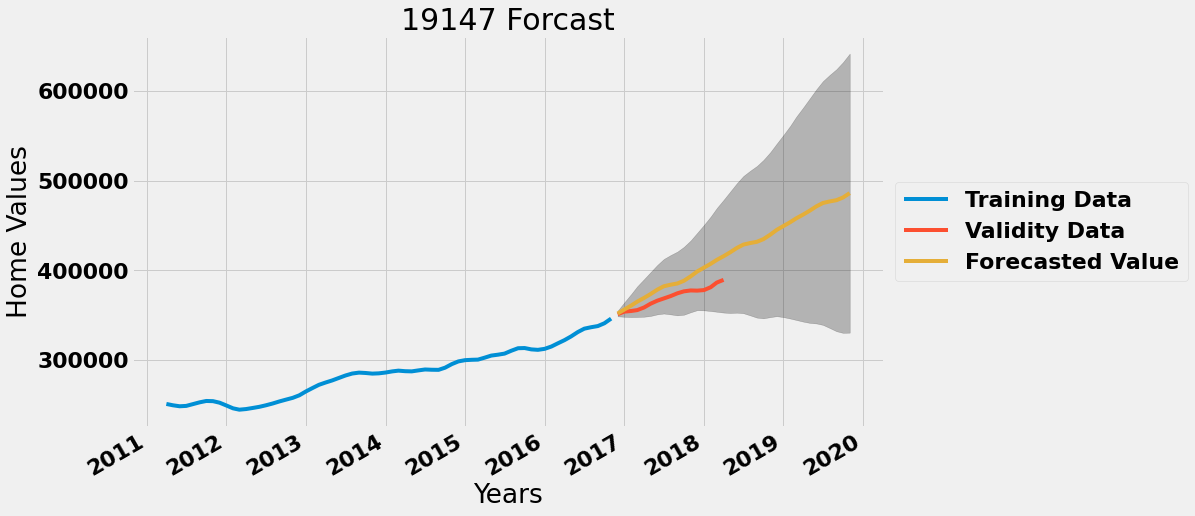

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           728.605
Name: 63, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5934      0.263      2.254      0.024       0.077       1.109
ma.L1          0.9377      0.102      9.150      0.000       0.737       1.139
ar.S.L12       0.1186      0.022      5.491      0.000       0.076       0.161
ma.S.L12      -0.2409      0.057     -4.227      0.000      -0.353      -0.129
sigma2      3.747e+06   6.24e-09   6.01e+14      0.000    3.75e+06    3.75e+06


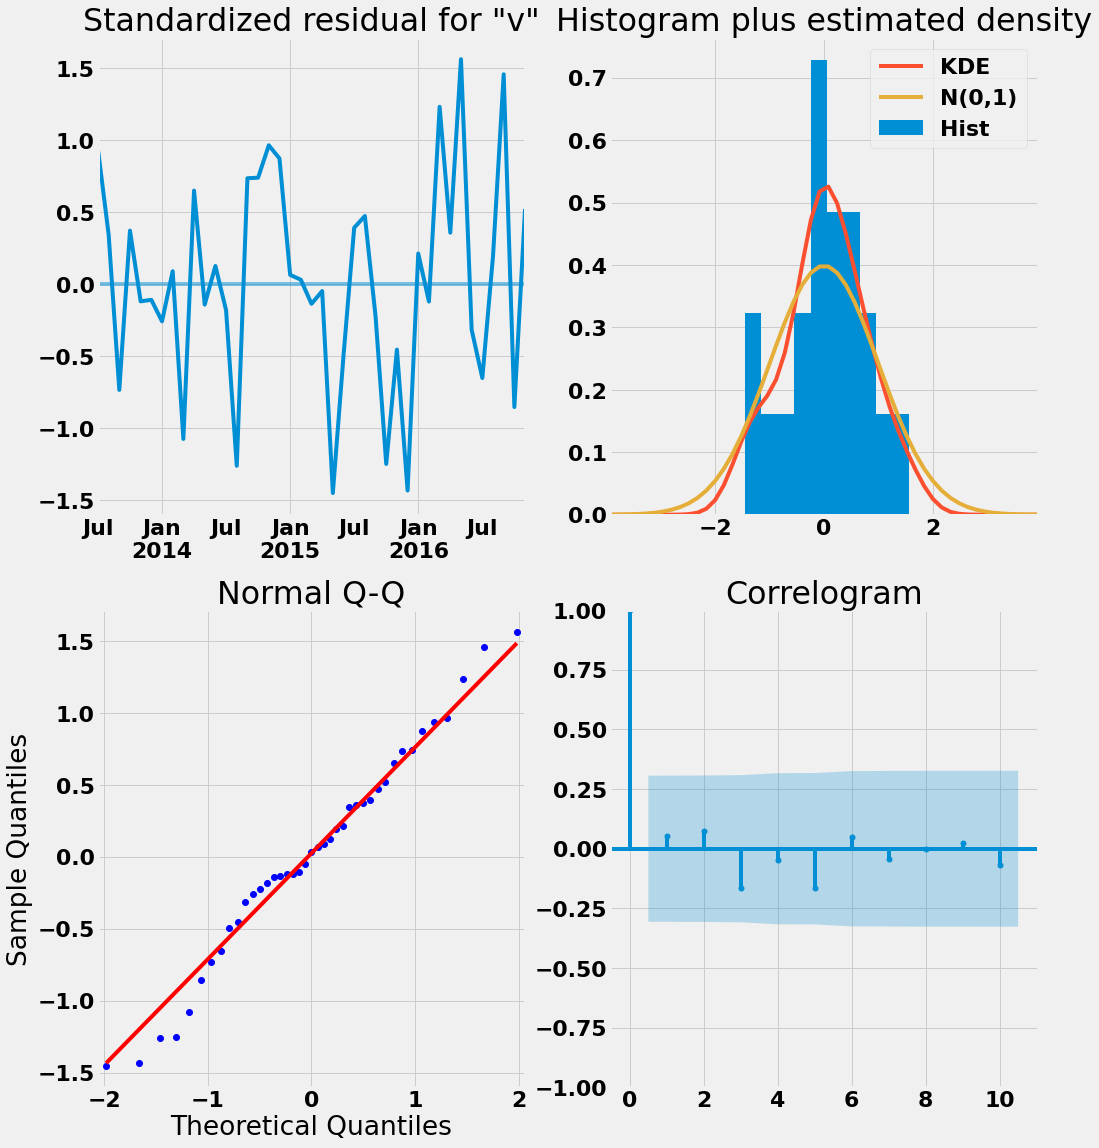

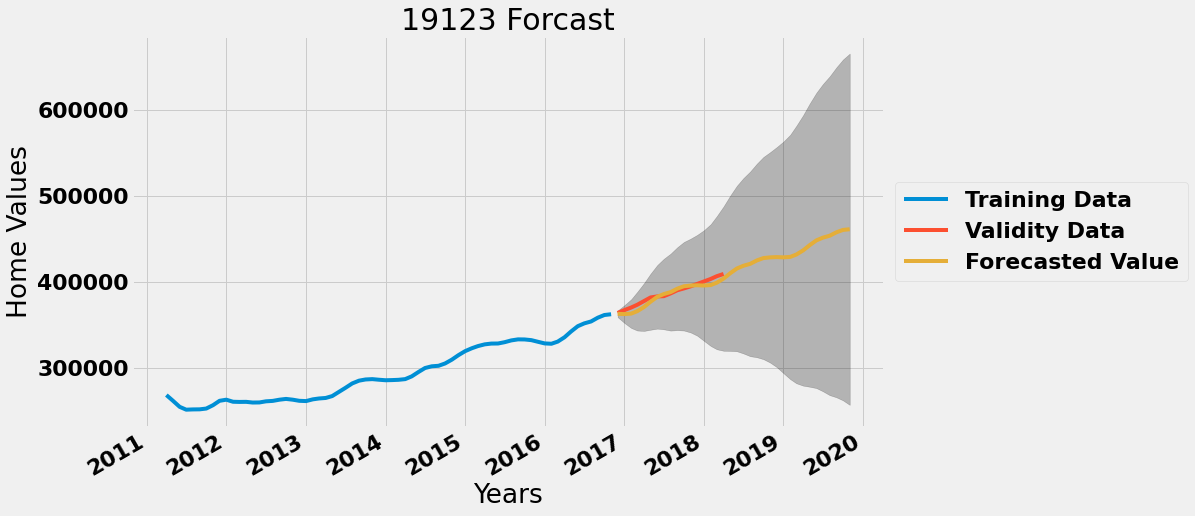

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           697.831
Name: 63, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6036      0.144      4.203      0.000       0.322       0.885
ma.L1          0.7609      0.133      5.735      0.000       0.501       1.021
ar.S.L12       0.1190      0.054      2.203      0.028       0.013       0.225
ma.S.L12      -0.5214      0.102     -5.131      0.000      -0.721      -0.322
sigma2       9.45e+05   1.67e+05      5.645      0.000    6.17e+05    1.27e+06


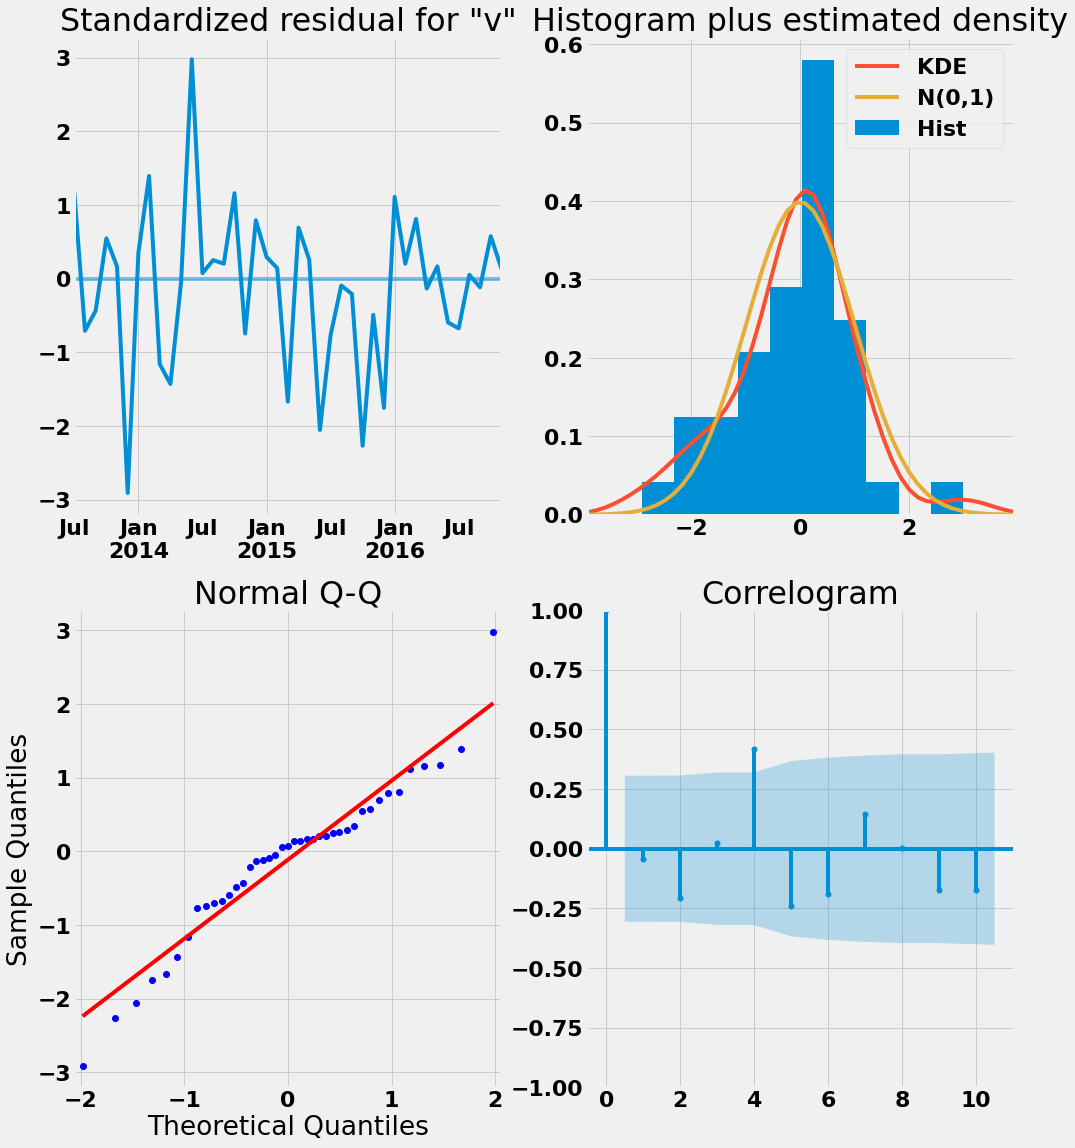

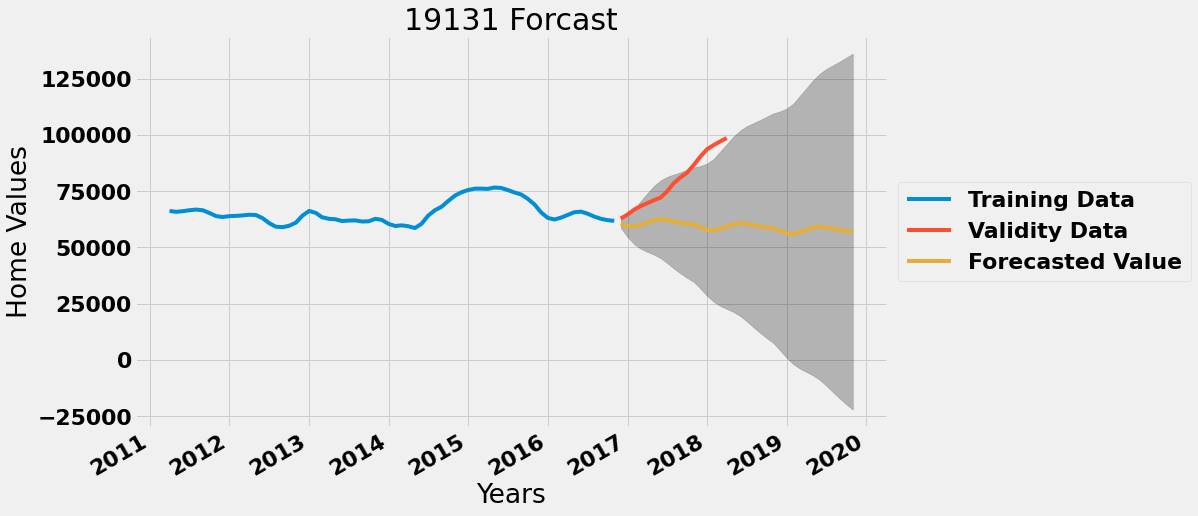

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           688.322
Name: 59, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8000      0.152      5.280      0.000       0.503       1.097
ma.L1          0.4807      0.169      2.850      0.004       0.150       0.811
ma.S.L12     -13.2687      8.526     -1.556      0.120     -29.980       3.442
sigma2      5132.4444   6484.718      0.791      0.429   -7577.370    1.78e+04


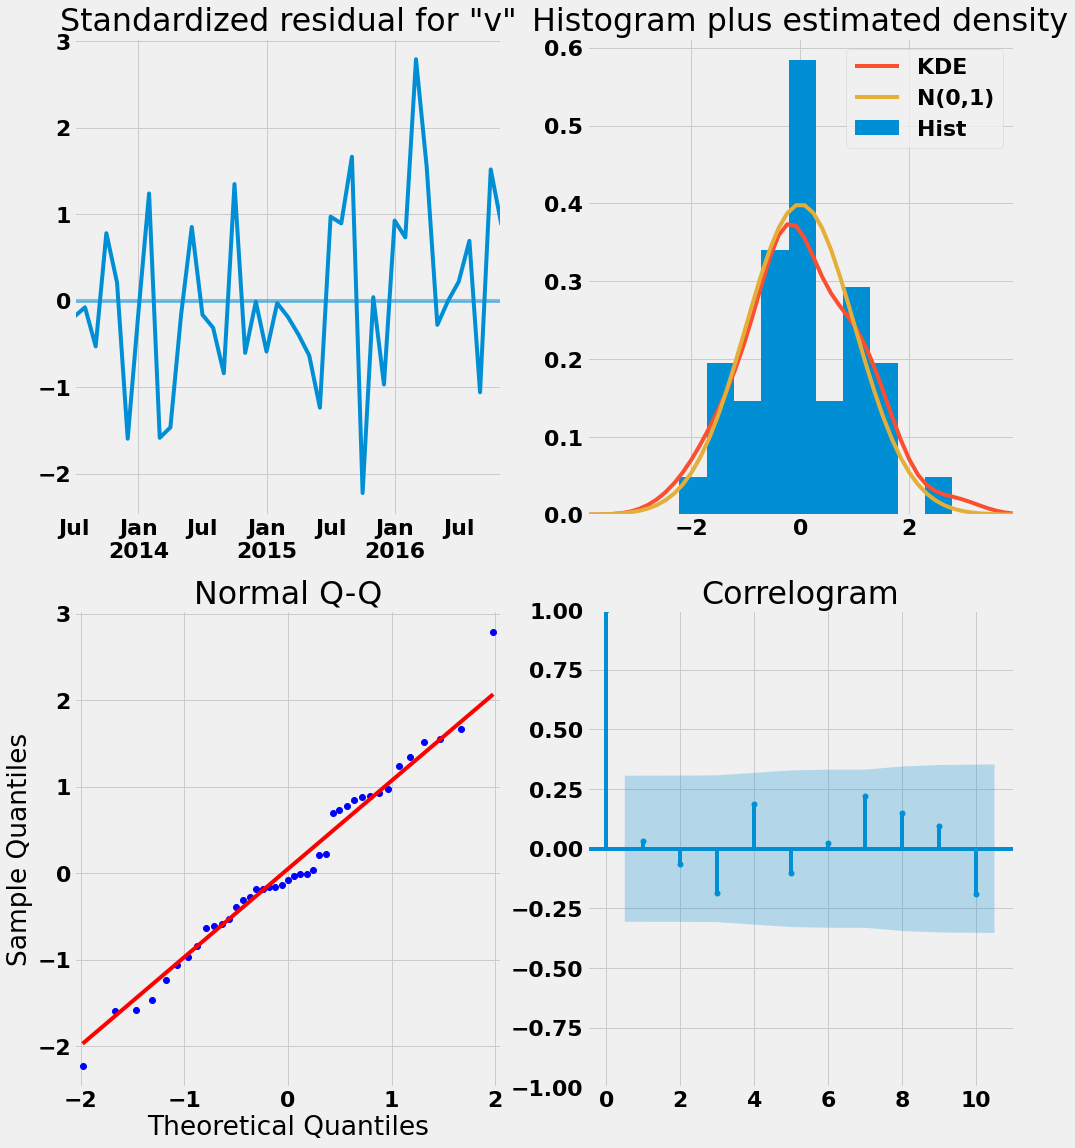

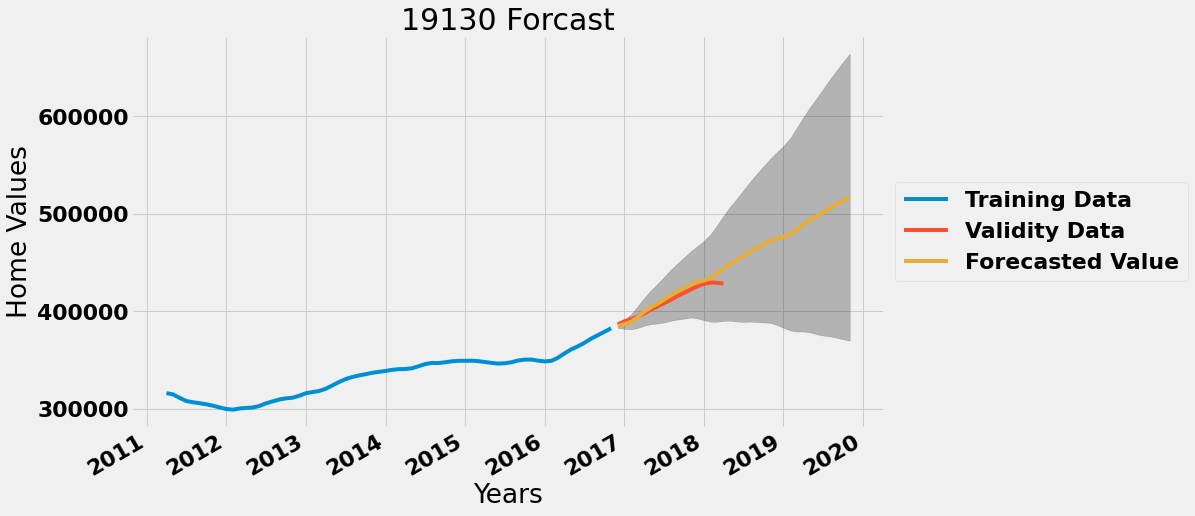

pdq         (0, 1, 1)
pdqs    (1, 1, 1, 12)
aic           785.834
Name: 31, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2125      0.124      1.715      0.086      -0.030       0.455
ar.S.L12      -0.5514      0.179     -3.088      0.002      -0.901      -0.201
ma.S.L12       0.0112      0.225      0.050      0.960      -0.429       0.451
sigma2      1.411e+07   5.84e-09   2.42e+15      0.000    1.41e+07    1.41e+07


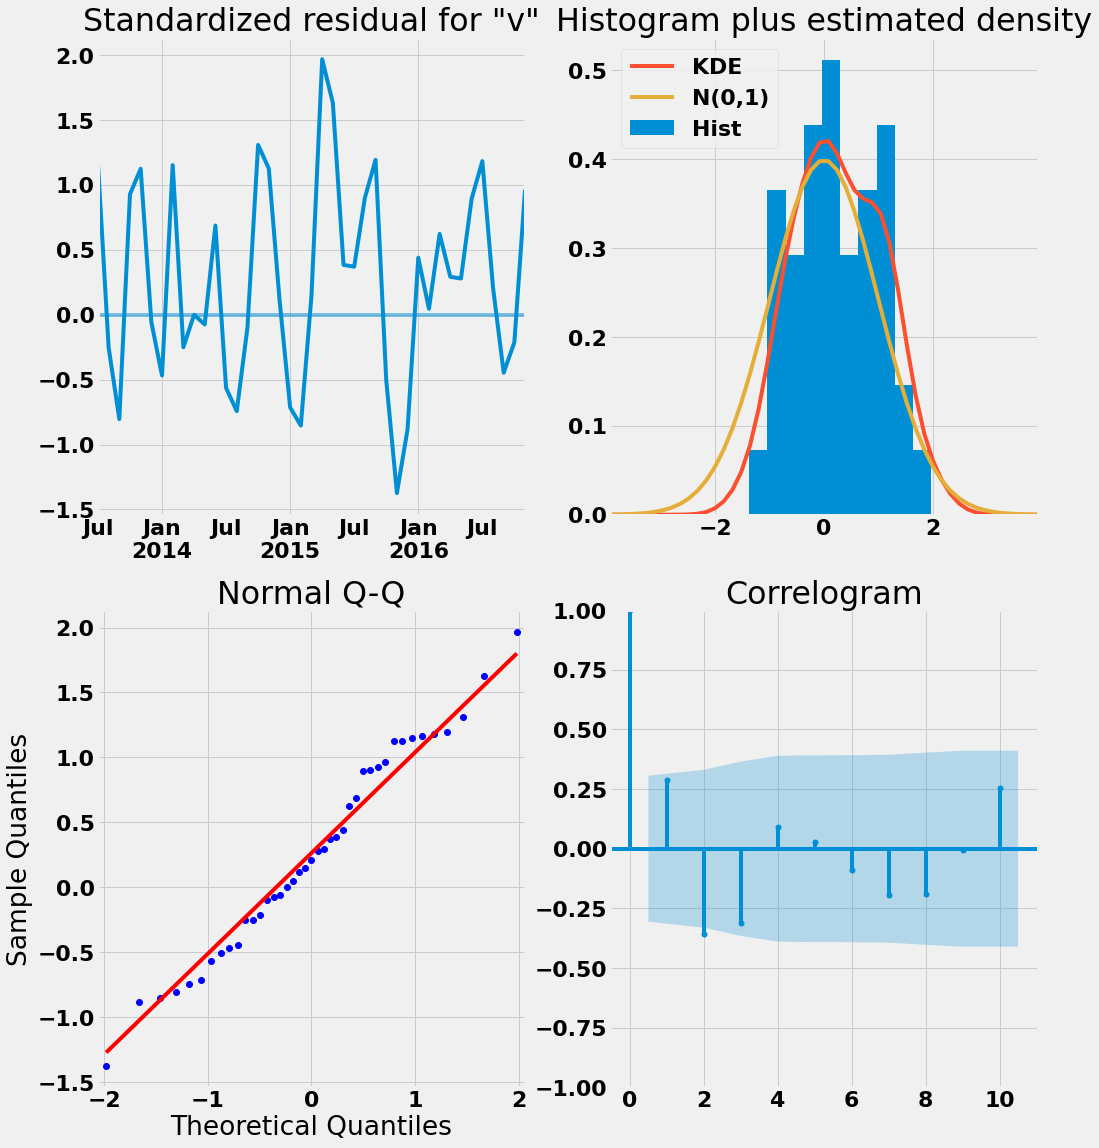

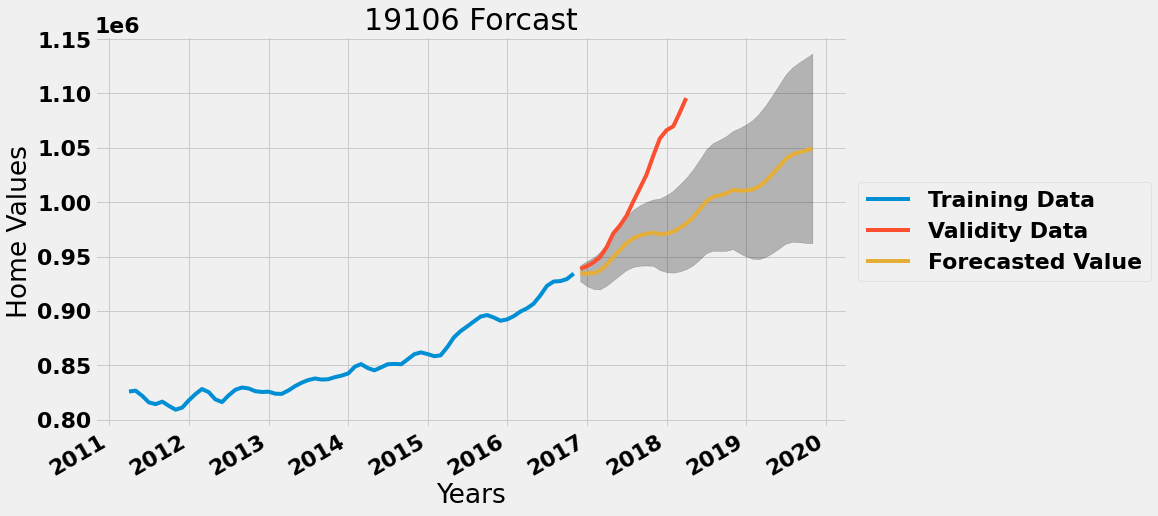

pdq         (0, 1, 1)
pdqs    (1, 1, 1, 12)
aic           689.823
Name: 31, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9966      0.233      4.282      0.000       0.540       1.453
ar.S.L12       0.0168      0.008      2.028      0.043       0.001       0.033
ma.S.L12      -0.0991      0.074     -1.347      0.178      -0.243       0.045
sigma2      9.821e+05    2.2e-07   4.46e+12      0.000    9.82e+05    9.82e+05


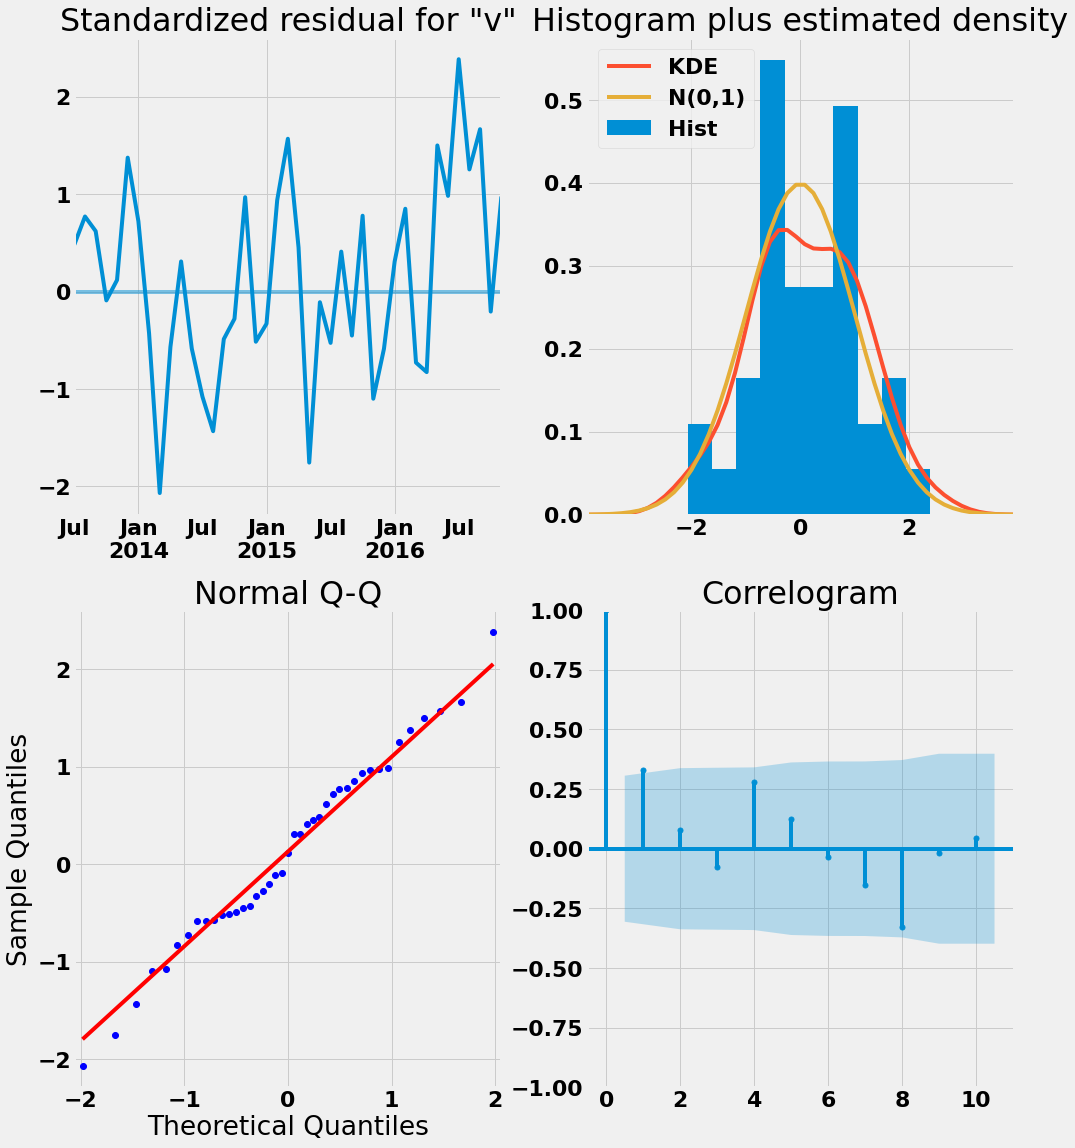

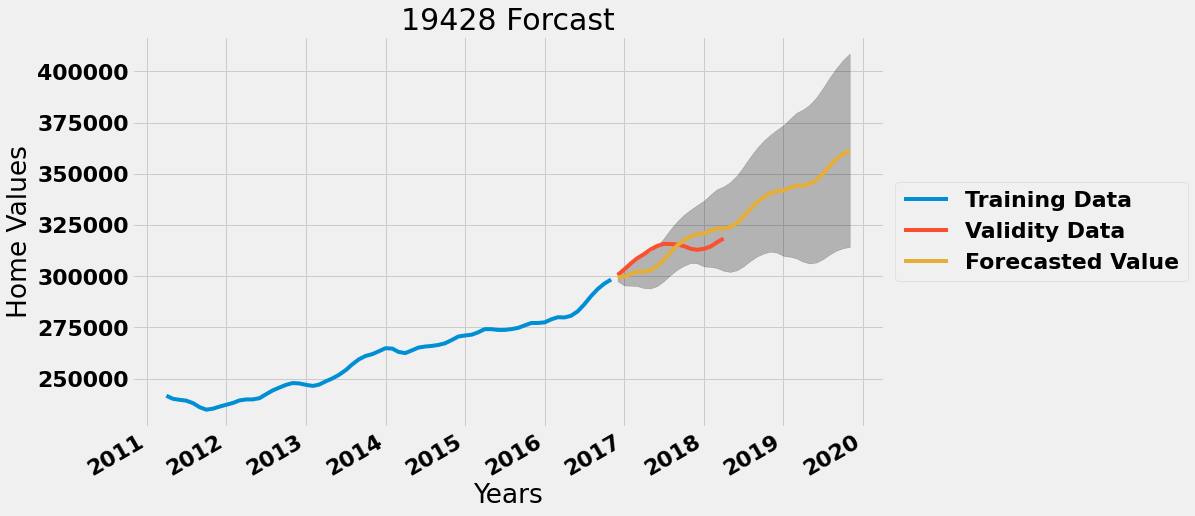

In [68]:
arima_models = []
for i in range(0, len(trainvalid_split)):
    arima_models.append(arima_model(trainvalid_split[i]['train'], trainvalid_split[i]['valid'], zip_list[i]))


In [106]:
rmses = []
for i in range(0, len(trainvalid_split)):
    rmses.append({
        'value': sqrt(mean_squared_error(trainvalid_split[i]['valid'], arima_models[i])),
        'zip_code': zip_list[i]
    })
    
sorted_rmses = sorted(rmses, key=lambda d: d['value']) 
sorted_rmses

[{'value': 1188.1884991178597, 'zip_code': '19148'},
 {'value': 4729.96288976945, 'zip_code': '19123'},
 {'value': 5551.760502149738, 'zip_code': '19130'},
 {'value': 6218.2858413917675, 'zip_code': '19145'},
 {'value': 6498.599797327099, 'zip_code': '19428'},
 {'value': 9557.453530464278, 'zip_code': '19125'},
 {'value': 16187.38275408695, 'zip_code': '19147'},
 {'value': 23286.896136253043, 'zip_code': '19131'},
 {'value': 40962.89267466064, 'zip_code': '19103'},
 {'value': 61282.51774356673, 'zip_code': '19106'}]

In [111]:
top_5_rmses = sorted_rmses[:5]
top_5_rmses

[{'value': 1188.1884991178597, 'zip_code': '19148'},
 {'value': 4729.96288976945, 'zip_code': '19123'},
 {'value': 5551.760502149738, 'zip_code': '19130'},
 {'value': 6218.2858413917675, 'zip_code': '19145'},
 {'value': 6498.599797327099, 'zip_code': '19428'}]